# Cornell Movie Dialog Dataset
Collection of conversations extracted from movie scripts, created by researchers at *Cornell University*

- Website: https://www.cs.cornell.edu/~cristian/Chameleons_in_imagined_conversations.html

- Dataset: http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip

- Paper: https://www.cs.cornell.edu/~cristian/papers/chameleons.pdf

**Citation:**
>Danescu-Niculescu-Mizil, C., & Lee, L. (2011).
>
> *Chameleons in imagined conversations: A new approach to understanding coordination of linguistic style in dialogs.*
>
> In Proceedings of the Workshop on Cognitive Modeling and Computational Linguistics, ACL 2011.



**NLP Group Assignment**
- Elif Gamze GULITER
- Romane KULESZA
- Volkan MAZLUM
- Juan Pablo RAMIREZ

**Politecnico di Milano**


The purpose of this notebook is to provide a comprehensive analysis and experimentation on the Cornell Movie Dialogue dataset, exploring various NLP techniques and models.

1. *Preliminary Analysis :* includes dataset statistics, basic conversation searches using regular expressions, indexing, dialogue clustering, topic modeling, and learning word embeddings.

2. *Specific Tasks :* begins with an experiment based on the dataset's original paper. Then explores film dialogue generation using multiple approaches: encoder-decoder models, encoder-decoder models with attention mechanisms, pre-trained encoder-decoder models such as Flan T5 for zero-shot learning, and transformers like DialoGPT and fine-tuned GPT-2. Later, the notebook addresses the prediction of metadata for specific dialogues, including multi-label classification of movie genres and rating predictions using both linear models and BERT fine-tuning.

3. *Extension Task :* details the creation of a movie character chatbot, encompassing speech-to-text conversion, GPT-2 fine-tuning to generate responses in the style of a specific movie character (e.g. Jack Sparrow), and text-to-speech synthesis.

**Objectives**
- Conduct comprehensive exploratory data analysis (EDA) to gain insights into the structure, content, and characteristics of the dataset.

- Apply various natural language processing (NLP) techniques and algorithms to analyze the dialogues within the dataset. (indexing, topic modeling, clustering, PoS tagging)

- Implement and compare various movie dialogue generation models (encoder-decoder, attention mechanisms, pre-trained models, fine-tuning).

- Build and evaluate classification regression models to predict metadata for movie dialogues (linear models, pre-trained models, fine-tuning).

- Develop a chatbot that can mimic the responses of a specific movie character, incorporating speech-to-text and text-to-speech functionalities for seamless interaction.

## 0. Initial Configuration

### Connect to Drive
**(optional for Google Colab users)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/NLP Cornell Movie Dataset/

Mounted at /content/drive/
/content/drive/My Drive/NLP Cornell Movie Dataset


### Download and unzip the Cornell Movie Dialog dataset
**(optional)**

In [ ]:
# Download and unzip the Cornell Movie Dialog dataset
download = False
if download:
  !curl -L -o cornell_movie_dialogs.zip http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
  !unzip cornell_movie_dialogs.zip

### Import Libraries

In [ ]:
!pip -q install python-terrier
#!pip -q install -U git+https://github.com/terrier-org/pyterrier.git
!pip -q install --upgrade gensim
!pip -q install einops
!pip -q install -U "ipywidgets>=7,<8"
!pip -q install ffmpeg-python
!pip -q install -U openai-whisper
!pip -q install -U datasets transformers
!pip -q install -U accelerate>=0.21.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.9/337.9 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.1 MB/s eta 0:00:00
  Preparing metadata (setup.p

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import NLP libraries
import re
import string

# NLTK
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.util import ngrams
from nltk.tag import pos_tag
from nltk.translate import bleu_score


from collections import Counter

# PyTerrier
import pyterrier as pt
if not pt.started():
  pt.init()

# Gensim
from gensim.models.word2vec import Word2Vec
from gensim.models import FastText
import gensim.downloader as gensim_downloader

# scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from imblearn.over_sampling import RandomOverSampler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, f1_score, mean_squared_error, r2_score

# HuggingFace transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer, EvalPrediction
from datasets import Dataset, DatasetDict

# Speech models
import ffmpeg
import whisper

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


terrier-assemblies 5.9 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.10.1 has loaded Terrier 5.9 (built by craigm on 2024-05-02 17:40) and terrier-helper 0.0.8



In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow_hub as hub
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
# Import torch
import torch
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(device)

2.3.0+cu121
cpu


In [ ]:
# Import other libraries
import ast
import pandas as pd
from scipy.stats import ttest_ind
import pickle
import io
import einops
from base64 import b64decode
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rc('font', size=12)

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from scipy.io.wavfile import read as wav_read
from scipy.io.wavfile import write as wav_write

### Text files inspection

First, we must visualize the content of each text file of the dataset in order to appropriately map them onto a data structure for subsequent analysis and manipulation within our NLP pipeline.

In [ ]:
# Dataset folder name (change it in case the dataset folder name is different)
DATASET_FOLDER = 'cornell movie-dialogs corpus'

In [ ]:
def inspect_txt(txt_filename, dataset_folder=DATASET_FOLDER, n=5):
  '''
  Function to inspect the first n lines of a text file
  params:
  - txt_filename (str): The name of the text file to inspect
  - base_path (str): The base path where the text file is located
  - lines (int): The number of lines to print from the text file. Default is 5.
  '''
  with open(os.path.join(os.getcwd(), dataset_folder, txt_filename), "r", encoding="iso-8859-1") as file:
    total_lines = 0
    for line in file:
      total_lines += 1
      if total_lines < n: print(line)
    print(f'...\nTotal lines: {total_lines}')

In [ ]:
# movie_title.txt
inspect_txt('movie_titles_metadata.txt')

m0 +++$+++ 10 things i hate about you +++$+++ 1999 +++$+++ 6.90 +++$+++ 62847 +++$+++ ['comedy', 'romance']

m1 +++$+++ 1492: conquest of paradise +++$+++ 1992 +++$+++ 6.20 +++$+++ 10421 +++$+++ ['adventure', 'biography', 'drama', 'history']

m2 +++$+++ 15 minutes +++$+++ 2001 +++$+++ 6.10 +++$+++ 25854 +++$+++ ['action', 'crime', 'drama', 'thriller']

m3 +++$+++ 2001: a space odyssey +++$+++ 1968 +++$+++ 8.40 +++$+++ 163227 +++$+++ ['adventure', 'mystery', 'sci-fi']

...
Total lines: 617


The file named *movie_title.txt* encompasses 617 lines, each detailing information regarding movies (identifier, title, release year, IMBD rating, number of IMBD votes, and genres).

The format of each line follows a structured pattern:

\<movie_id> +++\$+++ \<movie_title> +++\$+++ \<movie_year> +++\$+++ \<movie_IMBD_rating> +++\$+++ \<movie_IMDB_votes> +++\$+++ \<movie_genres>

In [ ]:
# raw_script_urls.txt
inspect_txt('raw_script_urls.txt')

m0 +++$+++ 10 things i hate about you +++$+++ http://www.dailyscript.com/scripts/10Things.html

m1 +++$+++ 1492: conquest of paradise +++$+++ http://www.hundland.org/scripts/1492-ConquestOfParadise.txt

m2 +++$+++ 15 minutes +++$+++ http://www.dailyscript.com/scripts/15minutes.html

m3 +++$+++ 2001: a space odyssey +++$+++ http://www.scifiscripts.com/scripts/2001.txt

...
Total lines: 617


The file named *raw_script_urls.txt* contains 617 lines, each with information regarding movie url references (movie identifier, mvie name, and reference url).

The format of each line follows a structured pattern:

\<movie_id> +++\$+++ \<movie_name> +++\$+++ \<url>

In [ ]:
# movie_characters_metadata.txt
inspect_txt('movie_characters_metadata.txt')

u0 +++$+++ BIANCA +++$+++ m0 +++$+++ 10 things i hate about you +++$+++ f +++$+++ 4

u1 +++$+++ BRUCE +++$+++ m0 +++$+++ 10 things i hate about you +++$+++ ? +++$+++ ?

u2 +++$+++ CAMERON +++$+++ m0 +++$+++ 10 things i hate about you +++$+++ m +++$+++ 3

u3 +++$+++ CHASTITY +++$+++ m0 +++$+++ 10 things i hate about you +++$+++ ? +++$+++ ?

...
Total lines: 9035


The file named *movie_characters_metadata.txt* encompasses 9035 lines, each containing data regarding movie characters (identifier, name, movie identifier, movie name, gender, and position in credits).

The format of each line follows a structured pattern:

\<character_id> +++\$+++ \<character_name> +++\$+++ \<movie_id> +++\$+++ \<movie_title> +++\$+++ \<character_gender> +++\$+++ \<character_pos_credits>

In [ ]:
# movie_lines.txt
inspect_txt('movie_lines.txt')

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!

L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!

L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.

L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?



The file named *movie_lines.txt* encompasses 304713 lines, each with information regarding movie line utterances (identifier, character identifier, movie identifier, character name, and text).

The format of each line follows a structured pattern:

\<utterance_id> +++\$+++ \<character_id> +++\$+++ \<movie_id> +++\$+++ \<character_name>+++\$+++ \<text>

In [ ]:
# movie_conversations.txt
inspect_txt('movie_conversations.txt')

The file named *movie_conversations.txt* contains 83097 lines, each with data regarding movie conversations (first character identifier, second character identifier, movie identifier, and list of line identifiers).

The format of each line follows a structured pattern:

\<character1_id> +++\$+++ \<character2_id> +++\$+++ \<movie_id> +++\$+++ \<line_identifiers>

### Load Cornell Movie Dialog Dataset

Following the examination of the .txt files, we proceed to ingest all data into structured Python dictionaries, facilitating convenient storage and access of the dataset.

In [ ]:
class CornellMovieDialogDataset:
  """
  Class to represent the Cornell Movie Dialog Dataset.

  Attributes:
    - base_path (str): The base path where the dataset files are located.
    - movies (dict): A dictionary to store movie metadata (indexed by movie ID).
        - title
        - year
        - IMBD_rating
        - IMBD_votes
        - genres
        - url
    - characters (dict): A dictionary to store character metadata (indexed by character ID).
        - name
        - movie_id
        - gender
        - pos_credits
    - utterances (dict): A dictionary to store movie lines (indexed by utterance ID).
        - character_id
        - movie_id
        - text
    - conversations (list): A list to store conversation data (represented as a list of utterance IDs).
  """
  def __init__(self, base_path):
    self.base_path = base_path
    self.movies = {}
    self.characters = {}
    self.utterances = {}
    self.conversations = []
    self.load_data()

  def load_data(self):
    """
    Loads the data from the dataset files into the class attributes.
    Uses original iso-8859-1 encoding of the dataset to read files
    """
    # Load movie titles
    with open(os.path.join(self.base_path, "movie_titles_metadata.txt"), "r", encoding="iso-8859-1") as file:
      for line in file:
        parts = [part.strip() for part in line.split("+++$+++")]
        self.movies[parts[0]] = {
            'title': parts[1],
            'year': int(re.match('\d+', parts[2])[0]),
            'IMDB_rating': float(re.match('[-+]?\d*\.\d+', parts[3])[0]),
            'IMDB_votes': int(re.match('\d+', parts[4])[0]),
            'genres': ast.literal_eval(parts[5])
        }

    # Load movie URL references
    with open(os.path.join(self.base_path, "raw_script_urls.txt"), "r", encoding="iso-8859-1") as file:
      for line in file:
        parts = [part.strip() for part in line.split("+++$+++")]
        self.movies[parts[0]]['url'] = parts[-1]

    # Load characters
    with open(os.path.join(self.base_path, "movie_characters_metadata.txt"), "r", encoding="iso-8859-1") as file:
      for line in file:
        parts = [part.strip() for part in line.split("+++$+++")]
        self.characters[parts[0]] = {
            'name': parts[1],
            'movie_id': parts[2],
            # ignore movie title (redundant)
            'gender': parts[4].lower(),
            'pos_credits': parts[5]
        }

    # Load movie lines
    with open(os.path.join(self.base_path, "movie_lines.txt"), "r", encoding="iso-8859-1") as file:
      for line in file:
        parts = [part.strip() for part in line.split("+++$+++")]
        self.utterances[parts[0]] = {
            'character_id': parts[1],
            'movie_id': parts[2],
            # ignore character name (redundant)
            'text': parts[4]
        }

    # Load conversations
    with open(os.path.join(self.base_path, "movie_conversations.txt"), "r", encoding="iso-8859-1") as file:
      for line in file:
        parts = [part.strip() for part in line.split("+++$+++")]
        self.conversations.append(ast.literal_eval(parts[3]))
        # ignore character ids / movie id (redundant)

  def print_summary(self):
    """
    Prints a summary of the dataset.
    """
    print(f'Number of movies: {len(self.movies)}')
    print(f'Number of characters: {len(self.characters)}')
    print(f'Number of utterances: {len(self.utterances)}')
    print(f'Number of conversations: {len(self.conversations)}')

  def print_random_conversation(self):
    """
    Prints a random conversation from the dataset.
    """
    random_conversation = random.choice(self.conversations)
    print(self.conversation_to_string(random_conversation))

  def conversation_to_string(self, conversation):
    '''
    Prints a conversation based on a list of utterance IDs.
    params:
    - conversation (list): A list of utterance IDs representing the conversation
    '''
    text = ''
    movie = self.movies[self.utterances[conversation[0]]['movie_id']]
    text += f"{movie['title']} ({movie['year']})\n"
    for line in conversation:
      text += f"{self.characters[self.utterances[line]['character_id']]['name']}: {self.utterances[line]['text']}\n"
    return text

  def get_utterance_texts_list(self):
    '''
    Function to retrieve all the dialog texts.
    returns:
    - texts (list): A list of texts of all dialogs in the dataset
    '''
    return [d['text'] for d in self.utterances.values()]

  def get_characters_by_movie(self, movie_id):
    '''
    Function to retrieve characters associated with a specific movie ID.
    params:
    - movie_id (str): The ID of the movie for which characters are to be retrieved
    returns:
    - characters (list): A list of character IDs associated with the specified movie ID
    '''
    characters = []
    for id, character in self.characters.items():
      if character['movie_id'] == movie_id:
        characters.append(id)
    return characters

  def get_utterances_by_movie(self, movie_id):
    '''
    Function to retrieve utterances associated with a specific movie ID.
    params:
    - movie_id (str): The ID of the movie for which utterance are to be retrieved
    returns:
    - utterances (list): A list of utterances IDs associated with the specified movie ID
    '''
    utterances = []
    for id, utterance in self.utterances.items():
      if utterance['movie_id'] == movie_id:
        utterances.append(id)
    return utterances

  def get_conversations_by_movie(self, movie_id):
    '''
    Function to retrieve conversations associated with a specific movie ID.
    params:
    - movie_id (str): The ID of the movie for which conversations are to be retrieved
    returns:
    - conversations (list): A list of lists of utterances IDs associated with the specified movie ID
    '''
    conversations = []
    for conversation in self.conversations:
      if self.utterances[conversation[0]]['movie_id'] == movie_id:
        conversations.append(conversation)
    return conversations

  def get_utterances_by_character(self, character_id):
    '''
    Function to retrieve utterances associated with a specific character ID.
    params:
    - character_id (str): The ID of the character for which utterance are to be retrieved
    returns:
    - utterances (list): A list of utterances IDs associated with the specified character ID
    '''
    utterances = []
    for id, utterance in self.utterances.items():
      if utterance['character_id'] == character_id:
        utterances.append(id)
    return utterances

  def get_conversations_by_character(self, character_id):
    '''
    Function to retrieve conversations associated with a specific character ID.
    params:
    - character_id (str): The ID of the character for which conversations are to be retrieved
    returns:
    - conversations (list): A list of lists of utterances IDs associated with the specified character ID
    '''
    conversations = []
    for conversation in self.conversations:
      for line in conversation:
        if self.utterances[line]['character_id'] == character_id:
          conversations.append(conversation)
          break
    return conversations


In [ ]:
# Instantiate dataset object and load data
dataset = CornellMovieDialogDataset(os.path.join(os.getcwd(), DATASET_FOLDER))

In [ ]:
dataset.print_summary()

Number of movies: 617
Number of characters: 9035
Number of utterances: 304713
Number of conversations: 83097


In [ ]:
dataset.print_random_conversation()

jfk (1991)
LOU: ...take a good look, chief, do any of 'em look like the hoboes you remember?
JIM: Hoboes I knew of old used to sleep in their clothes - these two look pretty young.
LOU: ...not a single frayed collar or cuff, new haircuts, fresh shaves, clean hands - new shoe leather. Look at the ear of the cop... That's a wire.  What's a cop wearing a headset for?  I think they're actors, chief; they're not cops.



## 1. Preliminary Analysis

### Dataset Statistics

In [1]:
def plot_numerical_attribute(attribute_name, attribute_value):
  '''
  Function to plot the distribution of a numerical attribute.
  params:
  - attribute_name (str): The name of the attribute being plotted
  - attribute_value (list): The values of the numerical attribute to be plotted
  '''
  plt.figure(figsize=(6, 2))
  sns.displot(attribute_value, kde=True, legend=False, color='skyblue', edgecolor='black')
  plt.title(f'Distribution of {attribute_name}')
  plt.xlabel(attribute_name)
  plt.ylabel('Frequency')
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.show()

# Function to visualize the distribution of categorical attributes
def plot_categorical_attribute(attribute_name, attribute_value):
  '''
  Function to plot a count distribution of a categorical attribute.
  It also prints the top 10 most frequent categories along with their percentages and counts.
  params:
  - attribute_name (str): The name of the categorical attribute
  - attribute_value (list): The values of the categorical attribute
  '''
  df = pd.DataFrame(attribute_value, columns=[attribute_name])
  plt.figure(figsize=(16, 2))
  sns.countplot(data=df, x=attribute_name, legend=False, order = df[attribute_name].value_counts().iloc[:20].index, color='lightgreen', edgecolor='black')
  plt.title(f'Count of {attribute_name}')
  plt.xlabel(attribute_name)
  plt.ylabel('Frequency')
  plt.yticks(fontsize=5)
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.show()
  print(pd.DataFrame(df, columns=[attribute_name]).value_counts(normalize=True).iloc[:10].mul(100).round(1).astype(str) + '%')
  print(pd.DataFrame(df, columns=[attribute_name]).value_counts().iloc[:10])

#### Movies

In [2]:
# Transform the movies dictionary to a Pandas DataFrame
movies_df = pd.DataFrame.from_dict(dataset.movies, orient='index')
movies_df['characters'] = [len(dataset.get_characters_by_movie(id)) for id in dataset.movies.keys()]
movies_df['utterances'] = [len(dataset.get_utterances_by_movie(id)) for id in dataset.movies.keys()]
movies_df['conversations'] = [len(dataset.get_conversations_by_movie(id)) for id in dataset.movies.keys()]

NameError: name 'pd' is not defined

In [ ]:
# Visualize movie release year statistics
plot_numerical_attribute('Release Year', movies_df['year'])
movies_df['year'].describe()

In [ ]:
# Visualize movie IMDB statistics
plot_numerical_attribute('IMDB Rating', movies_df['IMDB_rating'])
print(movies_df['IMDB_rating'].describe())
plot_numerical_attribute('IMDB Votes', movies_df['IMDB_rating'])
print(movies_df['IMDB_votes'].describe())
movies_df.plot(kind='scatter', x='IMDB_rating', y='IMDB_votes', s=32, alpha=.8)

In [ ]:
# Best movies
movies_df[movies_df['IMDB_votes'] > movies_df['IMDB_votes'].quantile(0.75)].sort_values(by=['IMDB_rating'], ascending=False).iloc[:10]

In [ ]:
# Visualize movie character utterance statistics
plot_numerical_attribute('Movie characters', movies_df['characters'])
print(movies_df['characters'].describe())
plot_numerical_attribute('Movie utterances', movies_df['utterances'])
print(movies_df['utterances'].describe())
plot_numerical_attribute('Movie conversations', movies_df['conversations'])
print(movies_df['conversations'].describe())
movies_df.plot(kind='scatter', x='characters', y='utterances', s=32, alpha=.8)

In [ ]:
# Visualize movie genre statistics
plot_categorical_attribute('Genres per movie', [len(d['genres']) for d in dataset.movies.values()])
plot_categorical_attribute('Genre combination', [str(d['genres']) for d in dataset.movies.values()])

In [ ]:
genres = []
for d in dataset.movies.values():
  genres += d['genres']
plot_categorical_attribute('Genres', genres)

In [ ]:
# Visualize movie url references statistics
plot_categorical_attribute('Reference URL', [re.findall('://www.([\w\-\.]+)', d['url'])[0] for d in dataset.movies.values() if len(re.findall('://www.([\w\-\.]+)', d['url']))>0])

**Movies Analysis**

| Attribute       | Mean    | Standard Deviation | Min  | 25%    | 50%     | 75%    | Max    |
|-----------------|---------|--------------------|------|--------|---------|--------|--------|
| Year            | 1988.58 | 16.59             | 1927 | 1984   | 1994    | 1999   | 2010   |
| IMDB Rating     | 6.86    | 1.22               | 2.5  | 6.2    | 7.0     | 7.8    | 9.3    |
| IMDB Votes      | 49820.96| 61880.61           | 9    | 9919   | 27112   | 66781  | 419312 |
| Characters      | 14.64   | 5.63               | 2    | 11     | 14      | 18     | 44     |
| Utterances      | 493.86  | 228.21             | 6    | 330    | 474     | 625    | 1530   |
| Conversations   | 134.68  | 51.63              | 1    | 98     | 133     | 166    | 338    |

Total amount of movies : 617

The average movie in the dataset was released around 1980-2000, has an IMDB rating of around 7, and received approximately 50k votes. The movies in the dataset typically feature around 10-20 characters, with approximately 300-600 utterances and 90-180 conversations. It is important to remark that the best movies are also the most popular ones (more votes implies better rating), and the more characters in the movie more dialog lines.

Additionally, drama is the most common genre, accounting for 17.1% of the movies, followed by thriller (14.4%), action (9.0%), and comedy (8.7%). The most common genre combination involves drama with the top being 'drama' (34 movies), followed by 'comedy, romance' (17 movies), 'crime, drama, thriller' (16 movies), 'comedy, drama, romance' (16 movies), 'comedy, drama' (15 movies), and 'drama, romance' (15 movies).

Moreover, the majority of scripts (64.9%) are sourced from dailyscript.com, followed by scifiscripts.com (13.0%) and horrorlair.com (6.9%).

#### Characters

In [ ]:
# Transform the characters dictionary to a Pandas DataFrame
characters_df = pd.DataFrame.from_dict(dataset.characters, orient='index')
characters_df['utterances'] = [len(dataset.get_utterances_by_character(id)) for id in dataset.characters.keys()]
#characters_df['conversations'] = [len(dataset.get_conversations_by_character(id)) for id in dataset.characters.keys()]

In [ ]:
# Visualize character gender statistics
plot_categorical_attribute('Character gender', [str(d['gender']) for d in dataset.characters.values()])

In [ ]:
# Visualize character position in credits statistics
plot_categorical_attribute('Credits position', [str(d['pos_credits']) for d in dataset.characters.values()])

In [ ]:
# Visualize character utterance statistics
plot_numerical_attribute('Character utterances', characters_df['utterances'])
print(characters_df['utterances'].describe())
plot_numerical_attribute('Character conversations', characters_df['conversations'])
print(characters_df['conversations'].describe())
characters_df.plot(kind='scatter', x='conversations', y='utterances', s=32, alpha=.8)

In [ ]:
# Characters with the most dialogs
characters_df.sort_values(by=['conversations'], ascending=False).iloc[:15]

In [ ]:
characters_df.sort_values(by=['utterances'], ascending=False).iloc[:15]

In [ ]:
# Characters with the least dialogs
characters_df.sort_values(by=['utterances'], ascending=True).iloc[:10]

In [ ]:
# Difference between main characters dialog count
print(characters_df[['utterances', 'conversations']].describe())
print('\nMain characters:')
print(characters_df[characters_df['pos_credits'].isin(['1','2','3','4'])][['utterances', 'conversations']].describe())
print('\nSecondary characters:')
print(characters_df[~characters_df['pos_credits'].isin(['1','2','3','4'])][['utterances', 'conversations']].describe())

**Characters Analysis**

Total characters: 9035

In terms of character gender, the majority of characters have an unspecified gender (?), comprising 66.6% of the dataset, followed by male (22.7%) and female (10.7%) characters.

Regarding credits position, the majority of characters hold an unspecified position (70.3%), while positions 1 to 9 constitute the remainder of the dataset.

Analyzing the utterances and conversations metrics provides further granularity; the median utterances and conversations counts across all characters are approximately 12 and 7, respectively. Notably, main characters (top positions in credits), representing 17.3% of the dataset, exhibit higher utterances 50-150 (107 on average) and conversations 30-90 (57 on average) compared to secondary or unranked characters, who contribute to the majority of the dataset with an around 3-30 utterances and 1-20 conversations.

#### Conversations

In [ ]:
# Visualize conversation statistics
plot_categorical_attribute('Utterances per conversation', [len(conversation) for conversation in dataset.conversations])

In [ ]:
# List of all dialog lines
texts = dataset.get_utterance_texts_list()

In [ ]:
# Visualize utterance statistics
plot_categorical_attribute('Sentences per utterance', [len(sent_tokenize(text)) for text in texts])

In [ ]:
# Visualize utterance statistics
plot_categorical_attribute('Words per utterance', [len([word for word in word_tokenize(text) if word not in string.punctuation]) for text in texts])

**Conversation Analysis**

Total utterances: 304713

Total conversations: 83097

Overall, there are 2-4 utterances per conversation, the majority of conversations comprise 2 utterances, accounting for 45.8% of the dataset, followed by 3 utterances at 21.0%, and 4 utterances with 11.4%. This distribution indicates a prevalent trend towards shorter interactions.

Furthermore, single-sentence utterances dominate the dataset, representing 60.8%, while 2 sentence per utterance represents 23.5% and multi-sentence utterances exhibit a negligible percentage with decreasing trend.

Finally, the average word count per utterance indicates that utterances tend to be concise, with the majority (68.4%) consisting of 1 to 8 words.


This analysis encapsulates the conversational dynamics and linguistic characteristics inherent in the dataset.

In [ ]:
def get_ngram_vocab(texts, n_gram=1):
  '''
  Generate vocabulary based on n-grams from a list of texts.
  params:
  - texts (list): List of strings containing the utterances
  - n_gram (int): The size of n-grams to generate. Default is 1 (unigrams)
  returns:
  - vocab (Counter): Counter object containing the n-gram vocabulary and their frequencies
  '''
  corpus_words = []
  for line in texts:
    line = line.strip().lower()
    corpus_words += [word for word in word_tokenize(line) if word not in string.punctuation]

  return Counter(ngrams(corpus_words, n_gram))

In [ ]:
# Vocabulary
vocab = get_ngram_vocab(texts)
print(f'{len(vocab)} distinct words (vocabulary size)')
vocab.most_common(200)

In [ ]:
# 2-grams
bigrams = get_ngram_vocab(texts, 2)
print(f'{len(bigrams)} distinct bigrams')
bigrams.most_common(200)

In [ ]:
# 3-grams
trigrams = get_ngram_vocab(texts, 3)
print(f'{len(trigrams)} distinct trigrams')
trigrams.most_common(200)

**Vocabulary Analysis**

- **Vocabulary size: 58,770**
- Distinct 2-grams: 755,752
- Distinct 3-grams: 1'968,321

The vocabulary and n-gram frequencies provides a glance of some patterns of language usage and common linguistic elements.

Vocabulary insights:
- Pronouns are the most frequent words in movie dialogues
- Followed by articles (really common in English) and action verbs
- Contractions are prominent (e.g. 's, n't, 've, 'd)
- Interesting frequent words
  - good/great
  - something/anything/nothing/everything/things
  - people
  - sorry/please
  - love
  - night/day
  - work
  - money
  - god/hell
  - sh\*\*/f\*\*k
  - old/new

2-gram and 3-gram insights:
- Contractions are prominent in movie dialogues (e.g. don't, I'm, it's, you're, that's)
- Common English constructions (verb + to), (pronoun + is), (pronoun + verb)...
- Interesting frequent 2/3-grams:
  - love you
  - thank you
  - I'm sorry
  - don't worry
  - of course
  - as soon as
  - don't know
  - I'm afraid
  - New York

**--> American drama movies**



### Basic Regular Expression conversation search
Retrieves all dialogues that matches the regular expression

In [ ]:
def dialogue_regex_search(regex_str):
  '''
  Searches for conversations containing a specified regex pattern.
  params:
  - regex_str (str): Regex pattern to search for in the conversation texts
  returns:
  - conversations (list): List of conversation IDs containing the specified regex pattern
  '''
  conversations = set()
  for conversation in dataset.conversations:
    for line_id in conversation:
      text = dataset.utterances[line_id]['text']
      if len(re.findall(regex_str, text)) > 0:
        conversations.add(str(conversation)) # found match in a line of the conversation
        break
  conversations = [ast.literal_eval(conv) for conv in conversations]
  return conversations

We can use the power of Regular Expressions to find patterns in the movie utterances and retrive the movie conversations that contain specific patterns.

Some examples of why this is useful:
- Search for emotions in the conversations
- Search for conversations that contain famous quotes
- Search for specific words or topics mentioned on conversations
- Search common phrases or dialogue dynamics
- Search for sentence structures and patterns

In [ ]:
# Example Regular Expression searches
regex_searches = ["happy|sad|angry|excited", "(M|m)ay the (F|f)orce be with you", "(B|b)etrayal", "everything's under control", "(I|i)f.+then.+\."]

for reg in regex_searches:
  print('-'*15)
  print(f'--> Regular Expression: "{reg}"')
  results = dialogue_regex_search(reg)
  print(f'{len(results)} conversations')
  for i in range(2):
    print(dataset.conversation_to_string(results[i]))

### Indexing

In [ ]:
def get_index_dataframe():
  '''
  Creates a DataFrame for indexing conversations in PyTerrier
  returns:
  - df (DataFrame): DataFrame containing indexed conversations with movie metadata
  '''
  df = []
  columns = ['docno', 'conversation', 'movie_title', 'movie_year', 'movie_rating', 'movie_votes', 'movie_genres']
  for conversation in dataset.conversations:
    movie = dataset.movies[dataset.utterances[conversation[0]]['movie_id']]
    row = [conversation[0], dataset.conversation_to_string(conversation),
           movie['title'], movie['year'], movie['IMDB_rating'], movie['IMDB_votes'], movie['genres']]
    df.append(row)
  return pd.DataFrame(df, columns=columns).applymap(str)

In [ ]:
# Get the DataFrame for indexing and searching
docs_df = get_index_dataframe()
docs_df.head()

In [ ]:
# Create index with Pyterrier
PT_INDEX_PATH = os.path.join(os.getcwd(), 'index_movie_dialogs')

indexer = pt.DFIndexer(PT_INDEX_PATH, overwrite=True)
# DEFAULT meta_reverse=['docno'], stemmer=TerrierStemmer.porter, stopwords=TerrierStopwords.terrier, tokeniser=TerrierTokeniser.english, type=IndexingType.CLASSIC,
index_ref = indexer.index(docs_df['conversation'], docs_df)
index = pt.IndexFactory.of(index_ref)

In [ ]:
# Index statistics
print(index.getCollectionStatistics().toString())

 - `Nt` is the number of unique documents that each term occurs in
 - `TF` is the total number of occurrences of term in corpus

In [ ]:
# Inspect frequency of interesting vocabulary terms
vocab_terms = ['love', 'work', 'feel', 'god', 'monei']
for term in vocab_terms:
  print(f'{term}: {index.getLexicon()[term].toString()}')

In [ ]:
def simple_query(batch_retriever, query, df):
  '''
  Perform a simple query and print the retrieved/ranked conversations
  params:
  - batch_retriever (BatchRetrieve): PyTerrier BatchRetrieve object configured with a retrieval model
  - query (str): Query text to search for.
  - df (DataFrame): DataFrame containing indexed conversations with document metadata
  '''
  results = batch_retriever.search(query)
  for docno in results['docno']:
    print(df[df['docno'] == docno]['conversation'].values[0])

In [ ]:
# (tf_idf % 50) >> (bm25 % 10() (retrieve top-50 using TF_IDF and rerank with BM25 to retrieve top-10)
br_pipeline = (pt.BatchRetrieve(index, wmodel="TF_IDF") % 50) >> (pt.BatchRetrieve(index, wmodel="BM25") % 10)
simple_query(br_pipeline, 'what is love', docs_df)

The index retrieved dialogues where love is the main topic or it is expressed by some character.

In [ ]:
simple_query(br_pipeline, 'star wars leaders', docs_df)

The index was able to retrieve the Star Wars movie dialogues were some leaders participate or are mentioned (e.g. red leader, gold leader, blue leader)

**Searching considering movie metadata**

In [ ]:
# Perform BM25 > create feature vector > retrieve top-200 according to query
# > rescore according to features > retrieve top-10 according to rescore
br_pipeline_metascoring = (pt.BatchRetrieve(index, wmodel="BM25", metadata=['docno', 'movie_year', 'movie_rating', 'movie_genres']) >> (
    pt.transformer.IdentityTransformer()
    ** # drama movies
    (pt.apply.doc_score(lambda row: int('drama' in row['movie_genres'])))
    ** # date between 1900 and 2000
    (pt.apply.doc_score(lambda row: int(1980 <= int(row['movie_year']) and 1990 > int(row['movie_year']))))
    ** # movie rating >= 7
    (pt.apply.doc_score(lambda row: int(7 <= float(row['movie_rating']))))
) % 200) >> (pt.apply.doc_score(lambda row: sum(row['features'])) % 10)

br_pipeline_metascoring.search('what is love')

In [ ]:
simple_query(br_pipeline_metascoring, 'what is love', docs_df)

The retrieval pipeline with additional scoring on some metadata was able to search for the best matches to the query and then filter them with certain properties as movie year, rating and genre. Clearly, the results changed from the base BM25 alone without considering metadata.

In [ ]:
simple_query(br_pipeline_metascoring, 'go away', docs_df)

From this point it is possbile to try different scorers, metadata and filters, but the results were quite good. The next step would be to create a better engine that learns how to rank (lambdaMART), but there are no qrels/labels to improve the ranking performance.

### Dialogue Clustering

- Load documents (conversations) to cluster
- Retrieve known labels of the documents (movie genres)

In [ ]:
cluster_df = get_index_dataframe()[['conversation', 'movie_genres']]
cluster_df['main_movie_genre'] = cluster_df['movie_genres'].apply(lambda x: ast.literal_eval(x)[0] if len(ast.literal_eval(x)) > 0 else 'drama')
cluster_df.head()

- 24 distinct movie genres
- 290 distinct genre combinations
- 2-4 genres per movie
- Drama and Thriller most frequent movie genres
- Between Drama, Comedy, Romance, and Thriller are the most frequent combinations

** For more statistics on movie genres, please refer to the Dataset Statistics section

In [ ]:
genres = []
for d in dataset.movies.values():
  genres += d['genres']
distinct_genres = sorted(list(set(genres)))

print(f'{len(distinct_genres)} distinct genres in the dataset:\n{distinct_genres}')

In [ ]:
print(f'{len(cluster_df)} conversations')
distinct_genre_combination = sorted(cluster_df['movie_genres'].unique())
print(f'{len(distinct_genre_combination)} distinct genre combinations')

In [ ]:
plot_categorical_attribute('Movie genre combination', [str(d['genres']) for d in dataset.movies.values()])

#### TF-IDF document vectorization
- Without most and least document frequent terms
- Without English stopwords
- 17,438 vocabulary size (huge space!)
- 18.17 average document (conversation) vocabulary size


In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
vector_documents = vectorizer.fit_transform(cluster_df['conversation'].values)
print(vector_documents.shape)

In [ ]:
vocab = vectorizer.get_feature_names_out()
print(f'Length of vocabulary: {len(vocab)}')
print()
print(f"Average document vocabulary size: {vector_documents.count_nonzero()/vector_documents.get_shape()[0]}")
print()
print('Sample vocabulary terms:')
print(sorted(random.sample(vocab.tolist(),100)))

In [ ]:
print('Inspection of first document:')
print(cluster_df['conversation'].values[0])
print()
print('Vector TF-IDF representation:')
print(vector_documents[0])
print()
print('Sorted TF-IDF score:')
sorted([(vocab[j], vector_documents[0, j]) for j in vector_documents[0].nonzero()[1]], key=lambda x: -x[1])

**Cosine similarity [0,1] between documents**

In [ ]:
index1 = random.randint(0, len(cluster_df)-1)
index2 = random.randint(0, len(cluster_df)-1)
print('Movie genre of first document:', cluster_df['movie_genres'].values[index1])
print('Movie genre of first document:', cluster_df['movie_genres'].values[index2])
print(f'Cosine similarity: {vector_documents[index1].multiply(vector_documents[index2]).sum()}')

Conversations are short, so it is hard to get a proper overlapping. However, there is some overlap on documents that share some movie genres.

**Cosine similarity keyword searching**

In [ ]:
query = 'italy'
query_vec = vectorizer.transform([query])[0]

index = np.argmax([query_vec.multiply(vector_documents[i]).sum() for i in range(len(cluster_df))])
print(cluster_df['conversation'].values[index])

Clearly, result not as fast and precise as the previous index search with BM25!

#### K-means clustering

In [ ]:
k_values = range(1, 30)
wcss = []

# Compute WCSS for each k
for k in k_values:
  kmeans = KMeans(n_clusters=k, max_iter=100)
  kmeans.fit(vector_documents)
  wcss.append(kmeans.inertia_)

# Plot the WCSS against k values
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.xticks(k_values)
plt.show()

According to the Elbow method, the biggest jump (decrease) of the WCSS is at around k=x, which do not correspond to the 24 distinct genres categories. This might be caused due to the genre combinations, length of documents, vectorization method, and not using cosine similarity as clustering distance.

Hence, K-means will be compared using k=24 and k=290

In [ ]:
# K = 24 distinct movie genres
kmeans = KMeans(n_clusters=len(distinct_genres), max_iter=100, n_init=2)
kmeans.fit(vector_documents)
k24_labels = kmeans.labels_

print('Top terms per cluster:')
for i in range(kmeans.n_clusters):
  centroid = kmeans.cluster_centers_[i]
  sorted_terms = centroid.argsort()[::-1]
  print(f"Cluster {i} ({np.sum(k24_labels == i)} docs):\t{[vocab[j] for j in sorted_terms[:10]]}")

In [ ]:
# K = 24 evaluation
print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_documents, k24_labels)))
print()
print('Extrinsic evaluation measures (on main movie genre):')
print("Homogeneity:", str(metrics.homogeneity_score(cluster_df['main_movie_genre'].values, k24_labels)))
print("Completeness:", str(metrics.completeness_score(cluster_df['main_movie_genre'].values, k24_labels)))
print("V-measure:", str(metrics.v_measure_score(cluster_df['main_movie_genre'].values, k24_labels)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(cluster_df['main_movie_genre'].values, k24_labels)))

In [3]:
# K = 290 distinct movie genre combination
kmeans = KMeans(n_clusters=len(distinct_genre_combination), max_iter=100, n_init=2)
kmeans.fit(vector_documents)
k290_labels = kmeans.labels_

print('Top terms per cluster:')
for i in range(kmeans.n_clusters):
  centroid = kmeans.cluster_centers_[i]
  sorted_terms = centroid.argsort()[::-1]
  print(f"Cluster {i} ({np.sum(k290_labels == i)} docs):\t{[vocab[j] for j in sorted_terms[:10]]}")

NameError: name 'KMeans' is not defined

In [ ]:
# K = 290 evaluation
print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_documents, k290_labels)))
print()
print('Extrinsic evaluation measures (on genre combination):')
print("Homogeneity:", str(metrics.homogeneity_score(cluster_df['movie_genres'].values, k290_labels)))
print("Completeness:", str(metrics.completeness_score(cluster_df['movie_genres'].values, k290_labels)))
print("V-measure:", str(metrics.v_measure_score(cluster_df['movie_genres'].values, k290_labels)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(cluster_df['movie_genres'].values, k290_labels)))

Transform the high dimensional data into low dimensional data (just 3 dimensions). For this, the linear dimensionality reduction technique called Singular Value Decomposition is used to transform the `vector_documents` to be 3 dimensional.

In [ ]:
svd = TruncatedSVD(3)
reduced_data = svd.fit_transform(vector_documents)

[x,y,z] = np.transpose(reduced_data)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(x, y, z, c=LabelEncoder().fit_transform(cluster_df['movie_genres'].values), marker='.')
ax.set_title('Original genre labelling')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(x, y, z, c=k24_labels, marker='.')
ax.set_title('K=24 clustering')

ax = fig.add_subplot(133, projection='3d')
ax.scatter(x, y, z, c=k290_labels, marker='.')
ax.set_title('K=290 clustering')

In [ ]:
cluster_df['k24_clustering'] = k24_labels
cluster_df['k290_clustering'] = k290_labels
cluster_df.head()

In [ ]:
cluster_df[cluster_df['k290_clustering'] == 34].tail(20)

In [ ]:
cluster_df[cluster_df['k290_clustering'] == 115].head(50)

It seems that some clusters are being mapped to specific movies and characters (label 34 correspind to "10 things i hate about you" and label 79 to "saving private ryan").
- cluster 34 centroid : ['10', 'hate', 'kat', 'things', 'patrick', 'bianca', '1999', 'cameron', 'joey', 'michael']
- cluster 79 centroid : ['ryan', 'miller', 'saving', 'private', 'reiben', '1998', 'sarge', 'upham', 'jackson', 'sir']

Meanwhile some clusters capture genre informarion, for instance cluster 115 detected some drama movie dialogues combined with other genres (e.g. "the cider house rules", "titanic", "black snake moan", "air force one", "15 minutes")
- cluster 115 centroid : ['rose', 'rambling', 'daddy', '1991', 'titanic', 'buddy', 'mother', 'homer', 'cider', 'don']

Both K-Means clustering models did not performed really good and were not able to classify documents by genre. Intrinsic measures indicate clusters do not segregate documents significantly, and extrinsic measures denote lack of matching to movie genres. This bad performance can be due to the following:
- very short documents
- conversations can belong to multiple movie genres
- used euclidean distance instead of cosine similarity
- weighted too much by movie metadata (title, year, characters)

However, due to the content of the conversations, lexically, clustering was able to group conversations by movie and characters instead of genres. This is why K=290 performed better, since there were more available clusters to assign to each movie.

#### Other Clustering Algorithms

In [ ]:
# DBSCAN with cosine similarity metric
dbscan = DBSCAN(metric='cosine', min_samples=100)
dbscan.fit(vector_documents)
dbscan_labels = dbscan.labels_

print(f'{len(np.unique(dbscan_labels))} clusters')
print()
print('Extrinsic evaluation measures (on main genre):')
print("Homogeneity:", str(metrics.homogeneity_score(cluster_df['main_movie_genre'].values, dbscan_labels)))
print("Completeness:", str(metrics.completeness_score(cluster_df['main_movie_genre'].values, dbscan_labels)))
print("V-measure:", str(metrics.v_measure_score(cluster_df['main_movie_genre'].values, dbscan_labels)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(cluster_df['main_movie_genre'].values, dbscan_labels)))
print()
print('Extrinsic evaluation measures (on genre combination):')
print("Homogeneity:", str(metrics.homogeneity_score(cluster_df['movie_genres'].values, dbscan_labels)))
print("Completeness:", str(metrics.completeness_score(cluster_df['movie_genres'].values, dbscan_labels)))
print("V-measure:", str(metrics.v_measure_score(cluster_df['movie_genres'].values, dbscan_labels)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(cluster_df['movie_genres'].values, dbscan_labels)))

Agglomerative Hierarchical Clustering takes too much time!

In [ ]:
# Agglomerative Hierarchical Clustering with cosine similarity metric and single linkage criteria
#agglomerative = AgglomerativeClustering(metric='cosine', linkage='average', compute_full_tree=False)
#agglomerative.fit(vector_documents.toarray())
#agglo_labels = agglomerative.labels_

Spectral Clustering takes all memory available!

In [ ]:
# Spectral clustering
#spectral = SpectralClustering(n_clusters=len(distinct_genres))
#spectral.fit(vector_documents)
#spectral_labels = spectral.labels_

Gaussian Mixture takes all memory available!

In [ ]:
# Gaussian Micture clustering
#gaussian = GaussianMixture(n_components=len(distinct_genres))
#gaussian.fit(vector_documents.toarray())
#gaussian_labels = gaussian.predict(vector_documents)

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(x, y, z, c=LabelEncoder().fit_transform(cluster_df['main_movie_genre'].values), marker='.')
ax.set_title('Original single genre labelling')

ax = fig.add_subplot(132, projection='3d')
ax.scatter(x, y, z, c=k24_labels, marker='.')
ax.set_title('K=24 K-means clustering')

ax = fig.add_subplot(133, projection='3d')
ax.scatter(x, y, z, c=dbscan_labels, marker='.')
ax.set_title('DBSCAN clustering')

In [ ]:
cluster_df['dbscan'] = dbscan_labels
cluster_df.head()

DBSCAN was the only clustering algorithm to test apart from K-means, because others like Spectral, Gaussian Mixture, and Agglomerative clustering used all memory available and take too long to converge.

In this sense, DBSCAN was able to identify 53 distinct clusters from the movie conversations, which is close to the original 24 distinct movie genres in the dataset. Moreover, the high completeness and low homogeneity illustrates that documents belonging to same movie genre are clustered together, but clusters are not pure because contain data points from other movie genres. Fortunately, this is the expected behavior since a movie dialogue can be classified with multiple movie genres simultaneously.

Finally, the 3D plot depicted that DBSCAN was able to learn the shape of the genre clusters more similarly to the original dataset using the main movie genre of the movie dialogue.

### Topic Modeling

Allows soft-clustering of conversations so that they can belong to multiple movie genres with certain probability (expected behavior as a movie can belong to multiple genres).

In [ ]:
topic_df = get_index_dataframe()[['conversation', 'movie_genres']]
topic_df.head()

In [ ]:
# Split documents randomly into 70% train and 30% test
documents_train, documents_test, label_train, label_test = train_test_split(topic_df['conversation'].values, topic_df['movie_genres'].values, test_size=0.2)
print('No. training docs:', len(documents_train))
print('No. testing docs:', len(documents_test))

#### Count document vectorization
- Without most and least frequent terms
- Without English stopwords
- 15,559 vocabulary size (smaller than TF-IDF)
- 18.17 average document (conversation) vocabulary size

In [ ]:
vectorizer = CountVectorizer(max_df=0.5, min_df=5, stop_words='english')
vector_documents_train = vectorizer.fit_transform(documents_train)
len(vector_documents_train.shape)

In [ ]:
vocab = vectorizer.get_feature_names_out()
print(f'Length of vocabulary: {len(vocab)}')
print()
print(f"Average document vocabulary size: {vector_documents.count_nonzero()/vector_documents.get_shape()[0]}")
print()
print('Sample vocabulary terms:')
print(sorted(random.sample(vocab.tolist(),100)))

#### Topic extraction using Latent Dirichlet Allocation (LDA)

- Identifies underlying topics by grouping words that frequently co-occur across documents

- Deals with polysemy, synonymy and short documents

In [ ]:
# Train LDA model
lda = LatentDirichletAllocation(n_components=len(distinct_genres), learning_method='online', max_iter=30)
lda.fit(vector_documents_train)

# Evaluate LDA model
vector_documents_test = vectorizer.transform(documents_test)
print(f'Perplexity: {lda.perplexity(vector_documents_test)}')

**Inspect most important terms learned for each topic**

In [ ]:
# Print most important terms for each topic
for i in range(len(lda.components_)):
  sorted_terms = lda.components_[i].argsort()[::-1]
  concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
  print(f'Topic {i + 1}:\t', concatenated_terms)

In [ ]:
# Prevalence of word in each topic
# Adapted from https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
num_words = 10
cols = 4
rows = int(len(lda.components_)/4)

fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 12})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

In the topic modeling with LDA context, the Perplexity metric indicates the level of "uncertainty" in the model's prediction result. Since the resulting 4,761 Perplexity value was high, suggests that the LDA model do not make good predictions and has poor fit on the data (not closely matching the actual distribution of words in the documents).

Additionally, the most important words in each topic either include movie-specific characters, dates and words, or English generic words (e.g. verbs, pronouns). Hence the topic modeling was not able to identify genres correctly according to the lexicon, but was able to recognize topics as movies or groups of movies with similar lexicon.

- Topic 5 might correspond to 2001 movies related to doctors and dead
- Topic 12 most important words are generic words
- Topic 14 might correspond to dialogues that involve characters and "love" word
- Topic 18 might correspond to dialogues where there is a meeting point involving male characters
- Topic 20 might correspind to Star Trek saga dialogues

**Visualizing topic representation learned compared to original movie genre**

Using t-distributed Stochastic Neighbor Embedding (t-SNE) dimensionality reduction technique

In [ ]:
tsne_embedding = TSNE(n_components=3).fit_transform(lda.transform(vector_documents_test))
tsne_embedding.shape

In [ ]:
[x, y, z] = np.transpose(tsne_embedding)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(x, y, z, c=LabelEncoder().fit_transform(label_test), marker='.')
ax.set_title('Original multi-genre labelling')

freq_topic = [topic_vec.argsort()[-1] for topic_vec in lda.transform(vector_documents_test)]
ax = fig.add_subplot(122, projection='3d')
ax.scatter(x, y, z, c=freq_topic, marker='.')
ax.set_title('LDA topic modeling')


The 3D visualization confirms the topics learned do not correspond to the movie genres, but to movies and groups of movies with similar vocabulary, as noted previously.

**Inspect topic modeling results with test documents**

In [ ]:
rand_index = random.randint(0, len(documents_test)-1)
doc = documents_test[rand_index]
print(doc)
print(f'Genres: {label_test[rand_index]}')

In [ ]:
# Vectorize and transform using LDA to generate the topic distribution of the document
doc_vec = vectorizer.transform([doc])[0]
topic_vec = lda.transform(doc_vec)[0]
topic_vec

In [ ]:
sorted_topics = topic_vec.argsort()[::-1]
sorted_prevalence = sorted(topic_vec)[::-1]

for i in range(10):
  if sorted_prevalence[i] < .01: break # Get rid of topics with probability < 1%
  topic = sorted_topics[i]
  sorted_terms = np.flip(lda.components_[topic].argsort())
  print (f'{100 * sorted_prevalence[i]:.1f}% Topic {topic}: {" ".join(vocab[i] for i in sorted_terms[:10])}')

The most important words of the most-likely topics of the conversation generally do not match with the movie dialogue. However, the ones that match typically are the dialogue date or characters involved.

In general, the topic modeling did not performed as good as expected, and was not able to identify genres, but movies, characters and dates. The task could be accomplished better if we encode conversations semantically, and not lexically, to detemine a conversation genre.

### Learn Word Embeddings

- Using **Word2Vec** to capture semantic relationships and contextual **word** meanings specific to movie dialogues.
- Using **FastText to capture semantic relationships and context of **subwords** information, enhancing the understanding of language used in movie dialogues.








In [ ]:
def tokenize_to_embeddings(texts):
  '''
  Tokenizes a list of texts into a list of word tokens suitable for word embeddings training.
  1. Sentence tokenization: Splits each text into sentences.
  2. Text normalization: Converts all text to lowercase.
  3. Word tokenization: Splits each sentence into words.
  4. Punctuation removal: Removes punctuation tokens.
  params:
  - texts (list): List of text documents to be tokenized
  returns:
  - List of word tokens from all input texts
  '''
  tokenized_sentences = []
  for text in texts:
    text_sent = sent_tokenize(text)
    for sent in text_sent:
      sent = sent.strip().lower()
      tokenized_sentence = word_tokenize(sent)
      tokenized_sentence = [word for word in tokenized_sentence if word not in string.punctuation]
      if len(tokenized_sentence) > 1:
        tokenized_sentences.append(tokenized_sentence)
  return tokenized_sentences

**Tokenize all the sentences in the movie dialogue dataset**

In [ ]:
tokenized_sentences = tokenize_to_embeddings(dataset.get_utterance_texts_list())

for sentence in tokenized_sentences[:10]:
  print(sentence)

**Train Word2Vec (CBOW) and FastText models on movie dialogue sentences**

In [ ]:
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=80, window=3, min_count=5, workers=4) # Default CBOW
word2vec_model.save('word2vec_movie_dialogues.model')
print(f'Vocabulary size (word vectors learnt): {len(word2vec_model.wv)}')

In [ ]:
fasttext_model = FastText(sentences=tokenized_sentences, vector_size=80, window=3, min_count=5, workers=4)
fasttext_model.save('fasttext_movie_dialogues.model')
print(f'Vocabulary size (word vectors learnt): {len(fasttext_model.wv)}')

**Inspect resulting word embeddings**

In [ ]:
terms = ['love', 'jedi', 'crime', 'house', 'italy', 'night']

print('Word2Vec model')
for term in terms:
  print(f"Most similar terms to '{term}':")
  print(word2vec_model.wv.most_similar(term)) # cosine similarity between embeddings
  print()

In [ ]:
print('FastText model')
for term in terms:
  print(f"Most similar terms to '{term}':")
  print(fasttext_model.wv.most_similar(term, topn=50)) # cosine similarity between embeddings
  print()

The trained word embedding models, Word2Vec and FastText, demonstrated distinct relationships between movie dialogue terms. Word2Vec was able to capture semantic meaning of words with respect to the movie dialogue corpus, while FastText showed a stronger lexical and phonetic influence of subwords, containing some semantics of the word.

**Word2Vec**
- "love" was closely associated with both positive and negative emotions contrary and related to love (e.g. hate, trust, fear, believe).
- "jedi" had connections to roles such as "pirate", "revolutionary", "tribe", and "patriot". This quites relates to what Star Wars Jedi are.
- "crime" according to the movie corpus involves concepts as "group" that does a "series" of "violation" and involves "weapon" and "drug".
- "house" was connected to compound words like "warehouse" and "household".
- "Italy" was mainly linked to adverbs (ending with 'ly') such as "potentially" and "romantically".
- "night" was related to temporal terms like "day", "weenend", and "week".

**FastText**
- "love" associated words like "glove", "beloved", "lover", and conjugations of the verb to love, together with some semantic relations to emotions such as "hate", "trust" and "betray".
- "jedi" was connected to names (e.g. malcolm, viola, macleod, valerie, joseph). Maybe the model related Star Wars jedi to people.
- "crime" had a mix of similar-sounding and related words like "prime" and "sublime".
- "house" was closely related to various types of buildings and rooms.
- "Italy" had geographical and historical associations.
- "night" was related to variations like "nightcap" and "nightclub", and to temporal terms like "day", "weenend", and "week".

Overall, Word2Vec was able to semantic relationships in the movie context, while FastText emphasizes phonetic similarities, reflecting distinct aspects of word associations in dialogues. Moreover, FastText allows to generate an embedding from words not seen in the original corpus by using subword embeddings.



In [ ]:
# Select random subset of terms and get their word vectors
sample = random.sample(list(word2vec_model.wv.key_to_index), 500)
word_vectors = word2vec_model.wv[sample]

# Fit and transform sample data to 3D using t-SNE model
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)
x, y, z = np.transpose(tsne_embedding)

# Plot word embeddings in 3D
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

The 3D plot of a sample of Word2Vec word embeddings of the movie dialogue dataset shows some interesting insights. Depeding on the random sample, the plot allows us to see how colors and animals have their own cluster in space, person names are sparsed all over the space, and that some semantically related words are close together.

## 2. Specific tasks

### Dataset paper *Chameleon Effect* Experiment

The Cornell Movie Dialogue Dataset is subject of the research paper titled "Chameleons in imagined conversations: A new approach to understanding coordination of linguistic style in dialogs," which explores the chameleon effect, where individuals nonconsciously adapt their use of function words to match their conversational partners.

Our goal is to replicate these findings by analyzing the dataset using Part-of-Speech (POS) tagging to detect stylistic convergence. Subsequently, we aim to leverage this understanding to develop a film dialogue generation chatbot that can produce more natural and contextually adaptive conversations.

**Chameleons in imagined conversations: A new approach to understanding coordination of linguistic style in dialogs**

https://www.cs.cornell.edu/~cristian/papers/chameleons.pdf

The paper explores the nonconscious coordination of humans to adapt to each other's use of function words, known as the chameleon effect, and how this is influenced by social status and gender roles. This behavior is partly innate due to evolutionary pressures that foster relationships, serving as a social strategy to gain approval and enhance comprehension.

**Key Research Question:**
The paper investigates whether scripted movie dialogues exhibit real-life stylistic convergence, where scriptwriters nonconsciously adjust respondents' replies to match the initiator's lexical choices.

**Methodology:**
- Analyzed the Cornell Movie Dialogue Dataset.
- Examined 9 LIWC-derived categories of stylistic features (earticles, auxiliary verbs, conjunctions, high-frequency adverbs impersonal pronouns, negations, personal pronouns, prepositions, and quantifiers).
- Measured convergence based on how one speaker's use of a feature triggers its use in the respondent's reply.
- Studied the effects of gender, narrative importance, and hostility.

**Results:**
- Found statistically significant convergence in all stylistic categories, demonstrating the chameleon effect.
- Showed that language coordination is deeply ingrained in conversational behavior.
- Females were found to be more influential than males in this coordination.
- Male characters adapted less in same-gender interactions (might be biased due to gender imbalance in the data).
- Lead characters converged more to second-billed characters than vice versa.

**Implications:**
Understanding this effect can improve human-computer interaction and aid in the construction of natural-language generation systems. It also has potential benefits for enhancing communication in organizational contexts, psychotherapy, care of the mentally disabled, and police-community interactions, ultimately improving communication between humans and between humans and computers.








In [ ]:
def retrieve_all_conversation_between_pairs(base_path):
  '''
  Retrieve all conversations between character pairs from the movie_conversations.txt file (faster than using data structure).
  params:
  - base_path (str): The base path where the dataset files are located
  returns:
  - list: List of all conversations between character pairs, where each conversation is a list of utterance IDs.
  '''
  conversations = []
  with open(os.path.join(base_path, "movie_conversations.txt"), "r", encoding="iso-8859-1") as file:
    char1_id = 'u'
    char2_id = 'u'
    temp = []
    for line in file:
      parts = [part.strip() for part in line.split("+++$+++")]
      # If character changes in text file
      if char1_id != parts[0] or char2_id != parts[1]:
        if len(temp) > 0: conversations.append(temp)
        char1_id = parts[0]
        char2_id = parts[1]
        temp = []
      temp.append(ast.literal_eval(parts[3]))
  return conversations

In [ ]:
def probs_conversations(group_conversations, stylistic_fam_pos):
  '''
  Calculate the probabilities of stylistic features manifesting in conversations.
  params:
  - group_conversations (list): List of grouped conversations, where each conversation is a list of utterance IDs.
  - stylistic_fam_pos (list): List of Part-of-Speech (PoS) tags representing a stylistic family.
  returns:
  - prob_both_manifest (float): Probability that both the utterance and its reply manifest the stylistic family.
  - prob_reply_manifest (float): Probability that the reply manifests the stylistic family.
  '''
  utt = 0
  utt_manifest = 0
  reply_manifest_to_utt_manifest = 0
  reply_manifest = 0

  for conv in group_conversations:
    for i in range(len(conv)-1):
      # Retrieve utterance and reply
      utterance = dataset.utterances[conv[i]]['text']
      reply = dataset.utterances[conv[i+1]]['text']

      # Generate PoS tags of utterance and reply
      utterance_pos = pos_tag(word_tokenize(utterance))
      reply_pos = pos_tag(word_tokenize(reply))

      # Detemine if utterance and reply manifest the stylistic family
      do_utterance_manifest = 0 < sum([1 if x[1] in stylistic_fam_pos else 0 for x in utterance_pos])
      do_reply_manifest = 0 < sum([1 if x[1] in stylistic_fam_pos else 0 for x in reply_pos])

      # Update counts
      utt += 1
      if do_reply_manifest: reply_manifest +=1
      if do_utterance_manifest:
        utt_manifest += 1
        if do_reply_manifest:
          reply_manifest_to_utt_manifest += 1

  prob_both_manifest = reply_manifest_to_utt_manifest/utt_manifest if utt_manifest > 0 else 0
  prob_reply_manifest = reply_manifest/utt if utt > 0 else 0

  return prob_both_manifest, prob_reply_manifest

**Chameleon Effect (coordination) linguistic experiment**

In [ ]:
# Dictionary for the Chameleon Effect linguistic experiment
chameleon_experiment = {
    'Adverb' : {
        'pos_tags': ['RB', 'RBR', 'RBS'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    },
    'Article' : {
        'pos_tags': ['DT'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    },
    'Aux_Verb' : {
        'pos_tags': ['MD'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    },
    'Conjunction' : {
        'pos_tags': ['CC', 'IN'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    },
    'Indef_Pronoun' : {
        'pos_tags': ['NN'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    },
    'Pers_Pronoun' : {
        'pos_tags': ['PRP'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    },
    'Preposition' : {
        'pos_tags': ['IN'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    },
    'Quantifier' : {
        'pos_tags': ['JJ'],
        'prob_both_manifest': [],
        'prob_reply_manifest': []
    }
}

In [ ]:
def chameleon_effect_probs(group_conversation, stylistic_fam_pos, prob_both_manifest, prob_reply_manifest):
  '''
  Calculate and append the probabilities of stylistic features manifesting in conversations for the Chameleon Effect.
  params:
  - group_conversation (list): List of grouped conversations, where each conversation is a list of utterance IDs
  - stylistic_fam_pos (list): List of Part-of-Speech (PoS) tags representing a stylistic family
  - prob_both_manifest (list): List to store probabilities that both the utterance and its reply manifest the stylistic family
  - prob_reply_manifest (list): List to store probabilities that the reply manifests the stylistic family

  returns:
  - prob_both_manifest (list): Updated list of probabilities that both the utterance and its reply manifest the stylistic family
  - prob_reply_manifest (list): Updated list of probabilities that the reply manifests the stylistic family
  '''
  for group in group_conversation:
    cond_prob, prob_manif = probs_conversations(group, stylistic_fam_pos)
    prob_both_manifest.append(cond_prob)
    prob_reply_manifest.append(prob_manif)

  return prob_both_manifest, prob_reply_manifest

**1. Retrieve all ordered pair of characters (A;B) dialogues**

In [ ]:
group_conversation = retrieve_all_conversation_between_pairs(DATASET_FOLDER)

**2. For all family features, estimate equation (1) Danescu-Niculescu-Mizil et al. (2011)**

$Conv_{A,B}(t) = P(b^t_a=1|a^t=1)-P(b^t_a=1)$

- $P(b^t_a=1|a^t=1) \approx$ fraction of *B* replies to *t*-manifesting *A* utterances that themselves exhibit *t*
- $P(b^t_a=1) \approx$ fraction of all replies of *B* to *A* that exhibit *t*

In [ ]:
for val in chameleon_experiment.values():
  chameleon_effect_probs(group_conversation, val['pos_tags'], val['prob_both_manifest'], val['prob_reply_manifest'])

# Save experiment dictionary (PoS tagging takes a lot of time)
with open('chameleon_experiment.pkl', 'wb') as fp:
    pickle.dump(chameleon_experiment, fp)

In [ ]:
# Retrieve experiment dictionary
with open('chameleon_experiment.pkl', 'rb') as fp:
  chameleon_experiment = pickle.load(fp)

**3. Paired t-test on probabilities differences for each linguistic family feature of the experiment**

In [ ]:
for k,v in chameleon_experiment.items():
  print('-'*100)
  print(k,':')
  print('Average P(b=1|a=1):', np.mean(v['prob_both_manifest']))
  print('Average P(b=1):', np.mean(v['prob_reply_manifest']))
  ttest = ttest_ind(v['prob_both_manifest'], v['prob_reply_manifest'])
  print(f'Statistical difference: {ttest[1]<0.01} ({ttest[1]} p-value)')

----------------------------------------------------------------------------------------------------
Adverb :
Average P(b=1|a=1): 0.44387262203956995
Average P(b=1): 0.46643373729771964
Statistical difference: True (3.3849405441601835e-12 p-value)
----------------------------------------------------------------------------------------------------
Article :
Average P(b=1|a=1): 0.47671039103899915
Average P(b=1): 0.5023139933981687
Statistical difference: True (6.223510938571436e-16 p-value)
----------------------------------------------------------------------------------------------------
Aux_Verb :
Average P(b=1|a=1): 0.18364319585500544
Average P(b=1): 0.19833472230654528
Statistical difference: True (6.387450846213957e-07 p-value)
----------------------------------------------------------------------------------------------------
Conjunction :
Average P(b=1|a=1): 0.46211358304578287
Average P(b=1): 0.49556470168485484
Statistical difference: True (1.087873179215389e-24 p-value)
----

**4. Plot convergence for each family showing the difference between the
means of probabilities**

In [ ]:
def plot_chameleon_experiment(data):
  '''
  Plot the probabilities of stylistic features manifesting in conversations for the Chameleon Experiment.
  params:
  - data (dict): Dictionary containing experiment data, where keys are stylistic feature categories and values are dictionaries with probabilities
  '''
  labels = list(data.keys())
  prob_both_manifest = [np.mean(data[key]['prob_both_manifest']) for key in labels]
  prob_reply_manifest = [np.mean(data[key]['prob_reply_manifest']) for key in labels]

  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots(figsize=(10, 6))
  rects1 = ax.bar(x - width/2, prob_both_manifest, width, label='Prob Both Manifest')
  rects2 = ax.bar(x + width/2, prob_reply_manifest, width, label='Prob Reply Manifest')

  # Add labels, title and custom x-axis tick labels
  ax.set_ylabel('Probabilities')
  ax.set_title('Chameleon Experiment Probabilities by POS Tag Category')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.tick_params(axis='x', labelsize=10)
  ax.legend()

  # Add data labels on top of the bars
  def add_labels(rects):
    for rect in rects:
      height = rect.get_height()
      ax.annotate(f'{height:.2f}',
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom')

  add_labels(rects1)
  add_labels(rects2)

  fig.tight_layout()

  plt.show()

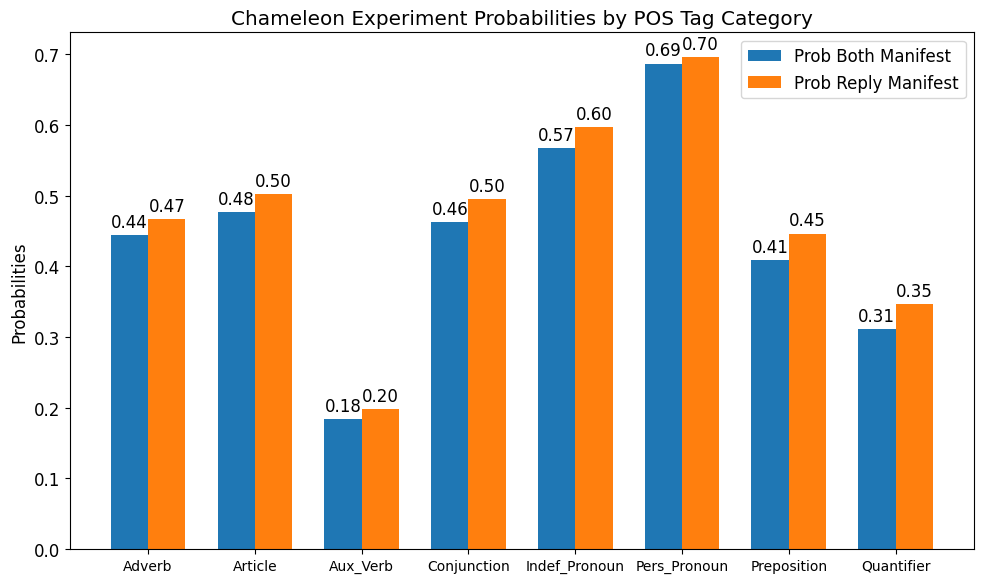

In [ ]:
plot_chameleon_experiment(chameleon_experiment)

As depicted in the results, across the various linguistic families (adverbs, articles, auxiliary verbs, conjunctions, indefinite pronouns, personal pronouns, prepositions, and quantifiers), there's a clear trend of higher probabilities for both the utterance and its reply manifesting the stylistic features when compared to the overall probability of manifestation. These differences are statistically significant, as indicated by the p-values obtained from the analysis. This suggests a strong tendency for conversational partners to adapt their linguistic style to match each other's, emphasizing the presence of the Chameleon Effect in scripted movie dialogues as stated in the paper (Danescu-Niculescu-Mizil et al., 2011).

### Film Dialog Generation

1-step dialog generation:

Given a context text, produce the next dialogue line to create iteratively the whole movie dialogue.

##### Dataset Creation

- Input = utterance *t*
- Output = reply to the utterance *t* in same dialog

In [ ]:
def generate_window_dataset(conversations, dataset_size, window=1):
  '''
  Generates a dataset of input-output conversation pairs with a sliding window approach.
  params:
  - conversations (list of utterances IDs): List of utterances IDs representing conversations
  - dataset_size (int): Maximum number of input-output pairs to generate
  - window (int): Size of the window for the input sequence. Defaults to 1
  returns:
  - input (list of list of str): Each inner list contains a sequence of utterances (strings) from the dataset
  - output (list of str): Each element is the reply corresponding to the sequence of utterances
  '''
  input = []
  output = []
  for conv in conversations:
    for i in range(len(conv)-window):
      # Retrieve utterances and reply
      utterances_window = []
      for j in range(i, i+window):
        utterances_window.append(dataset.utterances[conv[j]]['text'])
      utterances = ' \n '.join(utterances_window)
      reply = dataset.utterances[conv[i+window]]['text']

      input.append(utterances)
      output.append(reply)

    if len(output) > dataset_size: break

  return input, output

In [ ]:
NUM_EXAMPLES = 100000
context_1step, reply_1step = generate_window_dataset(dataset.conversations, NUM_EXAMPLES, window=1)

In [ ]:
BUFFER_SIZE = len(context_1step)
BATCH_SIZE = 64

# Create raw training 80% and validation 20% datasets
is_train = np.random.uniform(size=(len(reply_1step),)) < 0.8
train_raw = tf.data.Dataset.from_tensor_slices((np.array(context_1step)[is_train], np.array(reply_1step)[is_train])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_raw = tf.data.Dataset.from_tensor_slices((np.array(context_1step)[~is_train], np.array(reply_1step)[~is_train])).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

##### Encoder-Decoder Preprocessing

In [ ]:
def tf_encoder_standardize(text):
  '''
  Standardizes the input text for the encoder
  params:
  - text (tf.Tensor): tf.string containing the input text to be standardized
  returns:
  - tf.string containing the standardized text
  '''
  # Add spaces around punctuation
  text = tf.strings.regex_replace(text, '[.?!,;:]', r' \0 ')
  # Separate contractions
  text = tf.strings.regex_replace(text, '\'', r' \0')
  # Strip whitespace
  text = tf.strings.regex_replace(text, '\s+', r' ')
  text = tf.strings.strip(text)
  return text

def tf_decoder_standardize(text):
  '''
  Standardizes the input text for the decoder
  params:
  - text (tf.Tensor): tf.string containing the input text to be standardized
  returns:
  - tf.string containing the standardized text
  '''
  # Standardize the text using the encoder standardization function
  text = tf_encoder_standardize(text)
  # Add start and end tokens to the text
  text = tf.strings.join([START_TEXT, text, END_TEXT], separator=' ')
  return text

In [ ]:
END_TEXT = '[END]'
START_TEXT = '[START]'
SEP_TEXT = '\n'
max_vocab_size = 30000 # limits vocab huge dimensionality

# Create a TextVectorization layer for processing encoder context text
context_text_processor = tfkl.TextVectorization(
    standardize=tf_encoder_standardize,
    max_tokens=max_vocab_size,
    ragged=True)
# Adapt vectorization from the training dataset
context_text_processor.adapt(train_raw.map(lambda context, reply: context))

# Create a TextVectorization layer for processing decoder reply text
reply_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_decoder_standardize,
    max_tokens=max_vocab_size,
    ragged=True)
# Adapt vectorization from the training dataset
reply_text_processor.adapt(train_raw.map(lambda context, reply: reply))

In [ ]:
def process_text(context, reply):
  '''
  Processes the input context and reply texts for training a sequence-to-sequence model
  - Tokenizes and vectorizes the context and reply texts with their respective text processors
  - Splits the reply text into decoder input (without end token) and decoder output (without start token)
  params:
  - context (tf.Tensor): tf.string containing the context text
  - reply (tf.Tensor): tf.string containing the reply text
  returns:
  - context (tf.Tensor): Tokenized and vectorized context text as a dense tensor
  - targ_in (tf.Tensor): Tokenized and vectorized reply text (decoder input part) as a dense tensor
  - targ_out (tf.Tensor): Tokenized and vectorized reply text (decoder output part) as a dense tensor
  '''
  context = context_text_processor(context).to_tensor()
  reply = reply_text_processor(reply)
  dec_in = reply[:,:-1].to_tensor()
  dec_out = reply[:,1:].to_tensor()
  return (context, dec_in), dec_out

In [ ]:
# Apply the process_text function to the training and validation datasets
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

for (ex_context_tok, ex_dec_in), ex_dec_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_dec_in[0, :10].numpy())
  print(ex_dec_out[0, :10].numpy())

[   93   123     6   222     8  1036 12400  2076     2  2147]

[  3  56  12  41   6 275   2   0   0   0]
[ 56  12  41   6 275   2   4   0   0   0]


##### Encoder-Decoder

**Classic Encoder-Decoder model**

Adapted from: https://github.com/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb

Adapted from: https://github.com/AkshayAX/Text-generation/blob/main/tex_gen4.0.pdf


<div>
<img src="https://miro.medium.com/v2/resize:fit:1400/1*R8p3Xj4GHpfJy_p3MPqAVg.jpeg" alt="Encoder-Decoder" width="250"/>
</div>

*https://miro.medium.com/v2/resize:fit:1400/1R8p3Xj4GHpfJy_p3MPqAVg.jpeg*

In [ ]:
UNITS = 64
EMBEDDING_DIM = 64

In [ ]:
class EncoderModel(tfk.models.Model):
  def __init__(self, text_processor, embedding_dim, units):
    super(EncoderModel, self).__init__()
    # Useful attributes
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.embedding_dim = embedding_dim
    self.units = units

    # Layers
    self.embedding = tfkl.Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, mask_zero=True, name='encoder_embed')
    self.lstm_layer = tfkl.LSTM(units=self.units, return_state=True, name='encoder_lstm')

  def call(self, inputs):
    x = self.embedding(inputs)
    _, hidden_state, cell_state = self.lstm_layer(x)
    return hidden_state, cell_state

  def convert_input(self, texts):
    # Convert input texts to tensor tokenized and vectorized
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
class DecoderModel(tfk.models.Model):
  def __init__(self, text_processor, embedding_dim, units):
    super(DecoderModel, self).__init__()
    # Useful attributes
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tfkl.StringLookup(vocabulary=text_processor.get_vocabulary(),
                                        mask_token='', oov_token='[UNK]')
    self.id_to_word = tfkl.StringLookup(vocabulary=text_processor.get_vocabulary(),
                                        mask_token='', oov_token='[UNK]',
                                        invert=True)
    self.start_token = self.word_to_id(START_TEXT)
    self.end_token = self.word_to_id(END_TEXT)

    self.embedding_dim = embedding_dim
    self.units = units

    # Layers
    self.embedding = tfkl.Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, mask_zero=True, name='decoder_embed')
    self.lstm = tfkl.LSTM(units=self.units, return_sequences=True, return_state=True, name='decoder_lstm')
    self.dense = tfkl.Dense(self.vocab_size, name='decoder_dense')

  def call(self, inputs, hidden_state=None, cell_state=None):
    x = self.embedding(inputs)
    x, hidden_st, cell_st = self.lstm(x, initial_state=[hidden_state, cell_state]) # useful for receiving the encoder state
    output = self.dense(x)

    return output, hidden_st, cell_st

  # Functions for inference
  def get_initial_state(self, hidden_state, cell_state):
    # Creates start vector
    batch_size = tf.shape(hidden_state)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    # Defines initial 'done' vector
    done = tf.zeros([batch_size, 1], dtype=tf.bool)

    # Calls decoder to get initial decoder states
    embedded = self.embedding(start_tokens)
    _, hidden_st, cell_st = self.lstm(embedded, initial_state=[hidden_state, cell_state])

    return start_tokens, done, hidden_st, cell_st

  def tokens_to_text(self, tokens):
    # Transforms tokens back to texts using the text processor
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *[START] *', '')
    result = tf.strings.regex_replace(result, ' *[END] *$', '')
    return result

  def get_next_token(self, next_token, done, hidden_state, cell_state, temperature = 0.0):
    # Calls decoder to get next token logits and states
    logits, hidden_st, cell_st = self(next_token, hidden_state=hidden_state, cell_state=cell_state)

    if temperature == 0.0:
      next_token = tf.argmax(logits, axis=-1)
    else:
      logits = logits[:, -1, :]/temperature
      next_token = tf.random.categorical(logits, num_samples=1)

    # If end token produced, set 'done' vector
    done = done | (next_token == self.end_token)
    # Produces 0-padding when 'done'
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, [hidden_st, cell_st]

In [ ]:
encoder = EncoderModel(context_text_processor, EMBEDDING_DIM, UNITS)
context_hidden, context_state = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output hidden, shape (batch, s, units): {context_hidden.shape}')
print(f'Encoder output cell, shape (batch, s, units): {context_hidden.shape}')

Context tokens, shape (batch, s): (64, 68)
Encoder output hidden, shape (batch, s, units): (64, 64)
Encoder output cell, shape (batch, s, units): (64, 64)


In [ ]:
decoder = DecoderModel(reply_text_processor, EMBEDDING_DIM, UNITS)
logits, _, _ = decoder(ex_dec_in, context_hidden, context_state)

print(f'Input reply tokens shape: (batch, t) {ex_dec_in.shape}')
print(f'Logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

Input reply tokens shape: (batch, t) (64, 52)
Logits shape shape: (batch, target_vocabulary_size) (64, 52, 30000)


In [ ]:
class EncoderDecoderModel(tfk.models.Model):
  def __init__(self, encoder_text_processor, decoder_text_processor, embedding_dim, units):
    super(EncoderDecoderModel, self).__init__()

    # Encoder-Decoder Layers
    self.encoder = EncoderModel(encoder_text_processor, embedding_dim, units)
    self.decoder = DecoderModel(decoder_text_processor, embedding_dim, units)

  def call(self, data):
    encoder_input, decoder_input = data
    encoder_hidden_state, encoder_cell_state = self.encoder(encoder_input)
    decoder_output, decoder_hidden_state, decoder_cell_state = self.decoder(decoder_input, hidden_state=encoder_hidden_state, cell_state=encoder_cell_state)
    return decoder_output

  def generate(self, texts, max_len=50, temperature=0.0):
    # Process the input texts
    encoder_hidden_state, encoder_cell_sate = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Loop trough decoder
    tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
    next_token, done, new_hidden, new_cell = self.decoder.get_initial_state(encoder_hidden_state, encoder_cell_sate)

    for t in tf.range(max_len):  # Limit the length of the generation
      next_token, done, state = self.decoder.get_next_token(next_token, done, new_hidden, new_cell, temperature)
      tokens = tokens.write(t, next_token)
      if tf.reduce_all(done):
        break

    # Convert tokens to text
    tokens = tokens.stack()
    tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
    result_text = self.decoder.tokens_to_text(tokens)
    return result_text

In [ ]:
model = EncoderDecoderModel(context_text_processor, reply_text_processor, EMBEDDING_DIM, UNITS)

logits = model((ex_context_tok, ex_dec_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Reply tokens, shape: (batch, t) {ex_dec_in.shape}')
print(f'Output logits shape: (batch, t, target_vocabulary_size) {logits.shape}')
model.summary()

Context tokens, shape: (batch, s, units) (64, 68)
Reply tokens, shape: (batch, t) (64, 52)
Output logits shape: (batch, t, target_vocabulary_size) (64, 52, 30000)
Model: "encoder_decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_model_1 (EncoderMo  multiple                  1953024   
 del)                                                            
                                                                 
 decoder_model_1 (DecoderMo  multiple                  3903024   
 del)                                                            
                                                                 
Total params: 5856048 (22.34 MB)
Trainable params: 5856048 (22.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Compilation and Training**

In [ ]:
def masked_loss(y_true, y_pred):
  '''
  Computes the masked sparse categorical cross-entropy loss
  (masks out the losses where the true labels are padding)
  params:
  - y_true (tf.Tensor): Tensor of shape containing the true labels.
  - y_pred (tf.Tensor): Tensor of shape containing the predicted logits
  returns:
  - Scalar tensor representing the masked mean loss
  '''
  loss_fn = tfk.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = loss_fn(y_true, y_pred)

  mask = tf.cast(y_true != 0, loss.dtype) # mask off the losses on padding
  loss *= mask
  return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
# Compile model with masked sparse categorical cross-entropy loss and Adam optimizer
model.compile(optimizer=tfk.optimizers.Adam(), loss=masked_loss)

In [ ]:
# Expected loss for a uniform random distribution over the vocabulary
vocab_size = 1.0 * reply_text_processor.vocabulary_size()
print(f'expected_loss: {tf.math.log(vocab_size).numpy()}')

# Evaluate the model on the validation dataset
model.evaluate(val_ds, steps=20, return_dict=True)

expected_loss: 10.53452
20/20 [==============================] - 6s 192ms/step - loss: 10.5345


{'loss': 10.534502029418945}

In [ ]:
EPOCHS = 3

# Train model
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [ ]:
def plot_learning_curves(train_losses, val_losses):
  '''
  Plots the learning curves for training and validation loss over epochs
  - train_losses (list): Array containing the training loss for each epoch
  - val_losses (list): Array containing the validation loss for each epoch
  '''
  epochs = range(1, len(train_losses) + 1)
  plt.figure(figsize=(14,5))
  plt.plot(epochs, train_losses, marker='.', label='Training loss')
  plt.plot(epochs, val_losses, marker='.', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='lower right')

In [ ]:
# Plot learning curves
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
# Class for exporting a model with a generate function
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def generate(self, inputs):
    return self.model.generate(inputs)

In [ ]:
# Save the trained Encoder-Decoder model
export_encdec = Export(model)
tf.saved_model.save(export_encdec, 'encdec_generator',
                    signatures={'serving_default': export_encdec.generate})

**Film dialogue generation**

In [ ]:
# Load the trained Encoder-Decoder model
encdec_generator = tf.saved_model.load('encdec_generator')
_ = encdec_generator.generate(tf.constant(context_1step[:5])) # warmup
encdec_generator.generate(tf.constant(context_1step[:5]))[0].numpy().decode()

In [ ]:
def generate_movie_dialogue(generator, seed_text, num_lines):
  '''
  Generates a movie dialogue using a given text generation model
  - Repeatedly feed the generated next line back into the text generation model
  params:
  - generator: Text generation model capable of generating the next line of dialogue
  - seed_text (str): Initial seed text to start the dialogue generation process
  - num_lines (int): Number of lines of dialogue to generate.
  returns:
  - list: List containing the generated dialogue lines
  '''
  next_line = seed_text
  dialogue = [seed_text]
  # Generate lines of dialogue
  for line in range(num_lines-1):
    next_line = generator.generate(tf.constant([next_line]))[0].numpy().decode()
    next_line = re.sub(r'\s([,.!?;:\'])', r'\1', next_line).strip()
    dialogue.append(next_line)

  # Print the generated dialogue with alternating speaker labels
  for i in range(len(dialogue)):
    if i%2 == 0:
      print(f'A: {dialogue[i]}')
    else:
      print(f'B: {dialogue[i]}')

  return dialogue

In [ ]:
# Generate dialogue with the trained Encoder-Decoder model
generated_dialogue = generate_movie_dialogue(encdec_generator, 'You\'re doing really good, keep up the good work!', 6)

A: You're doing really good, keep up the good work!
B: I'm course you don't I'm course you don't I'm course you don't I'm course you don't I'm course you don't I'm course you don't I'm course you don't I'm course you don't I'm
A: I'm course...............................................
B: Yes, I don't course, I don't course, I don't course, I don't course, I don't course, I don't course, I don't course, I don't course, I don't course, I don't
A: I'm course, I'm course, I'm course, I'm course, I'm course, I'm course, I'm course, I'm course, I'm course, I'm course, I'm course, I'm course, I'm
B: I'm course...............................................


In [ ]:
def bleu(ref, gen):
  '''
  calculate pair wise bleu score from nltk implementation
  params:
  - references (list) : List of reference sentences
  - candidates (list) : List of generated sentences
  returns:
  - float bleu score
  '''
  ref_bleu = []
  gen_bleu = []
  for l in gen:
    gen_bleu.append(l.split())
  for i,l in enumerate(ref):
    ref_bleu.append([l.split()])

  score_bleu = bleu_score.corpus_bleu(ref_bleu, gen_bleu,
                           weights=(0, 1, 0, 0),
                           smoothing_function=bleu_score.SmoothingFunction().method4)
  return score_bleu

In [ ]:
num_samples = 100
rand_index = np.random.choice(len(context_1step), num_samples)

ref = np.array(reply_1step)[rand_index]
gen = [tfs.decode() for tfs in encdec_generator.generate(tf.constant(np.array(context_1step)[rand_index])).numpy()]

print(f'BLEU score for random texts: {bleu(ref, gen)}')

BLEU score for random texts: 0.000196754367586395


The Encoder-Decoder model performs really bad generating movie dialogues, since it struggles to generate coherent phrases, lack meaning, and it's repetitive.

Its low BLEU score indicates significant divergence from human-generated dialogue.

##### Encoder-Decoder with Attention

**Encoder-Decoder with Attention (Bahdanau attention model)**

Adapted from: https://github.com/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb

Adapted from: https://github.com/AkshayAX/Text-generation/blob/main/tex_gen4.0.pdf


<div>
<img src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention.png" alt="Encoder-Decoder-Attention" width="250"/>
</div>

*https://www.tensorflow.org/images/tutorials/transformer/RNN+attention.png*



In [ ]:
UNITS = 64
EMBEDDING_DIM = 64

In [ ]:
class BiEncoderModel(tfk.models.Model):
  def __init__(self, text_processor, embedding_dim, units):
    super(BiEncoderModel, self).__init__()
    # Useful attributes
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.embedding_dim = embedding_dim
    self.units = units

    # Layers
    self.embedding = tfkl.Embedding(input_dim=self.vocab_size,
                                    output_dim=self.embedding_dim,
                                    mask_zero=True, name='encoder_embed')
    self.bigru_layer = tfkl.Bidirectional(merge_mode='sum',
                                         layer=tfkl.GRU(self.units,
                                                    return_sequences=True,
                                                    recurrent_initializer='glorot_uniform'))

  def call(self, inputs):
    x = self.embedding(inputs)
    x = self.bigru_layer(x)
    return x

  def convert_input(self, texts):
    # Convert input texts to tensor tokenized and vectorized
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
class CrossAttention(tfkl.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tfkl.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tfkl.LayerNormalization()
    self.add = tfkl.Add()

  def call(self, x, context):
    attn_output, attn_scores = self.mha(query=x,
                                        value=context,
                                        return_attention_scores=True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
class DecoderAttentionModel(tfk.models.Model):
  def __init__(self, text_processor, embedding_dim, units):
    super(DecoderAttentionModel, self).__init__()
    # Useful attributes
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tfkl.StringLookup(vocabulary=text_processor.get_vocabulary(),
                                        mask_token='', oov_token='[UNK]')
    self.id_to_word = tfkl.StringLookup(vocabulary=text_processor.get_vocabulary(),
                                        mask_token='', oov_token='[UNK]',
                                        invert=True)
    self.start_token = self.word_to_id(START_TEXT)
    self.end_token = self.word_to_id(END_TEXT)

    self.embedding_dim = embedding_dim
    self.units = units

    # Layers
    self.embedding = tfkl.Embedding(input_dim=self.vocab_size,
                                    output_dim=self.embedding_dim, mask_zero=True,
                                    name='decoder_embed')
    self.gru = tfkl.GRU(units=self.units, return_sequences=True,
                        return_state=True, recurrent_initializer='glorot_uniform',
                        name='decoder_gru')
    self.attention = CrossAttention(self.units)
    self.dense = tfkl.Dense(self.vocab_size, name='decoder_dense')

  def call(self, context, x, state=None):
    x = self.embedding(x)
    x, state = self.gru(x, initial_state=state) # useful for receiving the encoder state
    x = self.attention(x, context)
    output = self.dense(x)

    return output, state

  # Functions for inference
  def get_initial_state(self, context):
    # Creates start vector
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    # Defines initial 'done' vector
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    # Calls decoder to get initial decoder states
    embedded = self.embedding(start_tokens)

    return start_tokens, done, self.gru.get_initial_state(embedded)[0]

  def tokens_to_text(self, tokens):
    # Transforms tokens back to texts using the text processor
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *[START] *', '')
    result = tf.strings.regex_replace(result, ' *[END] *$', '')
    return result

  def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    # Calls decoder to get next token logits and states
    logits, state = self(context, next_token, state=state)

    if temperature == 0.0:
      next_token = tf.argmax(logits, axis=-1)
    else:
      logits = logits[:, -1, :]/temperature
      next_token = tf.random.categorical(logits, num_samples=1)

    # If end token produced, set 'done' vector
    done = done | (next_token == self.end_token)
    # Produces 0-padding when 'done'
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

In [ ]:
biencoder = BiEncoderModel(context_text_processor, EMBEDDING_DIM, UNITS)
ex_context = biencoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 68)
Encoder output, shape (batch, s, units): (64, 68, 64)


In [ ]:
attention_layer = CrossAttention(UNITS)
embed = tfkl.Embedding(reply_text_processor.vocabulary_size(),
                                  output_dim=EMBEDDING_DIM, mask_zero=True)
ex_dec_embed = embed(ex_dec_in)
result = attention_layer(ex_dec_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Reply sequence, shape (batch, t, units): {ex_dec_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')

Context sequence, shape (batch, s, units): (64, 68, 64)
Reply sequence, shape (batch, t, units): (64, 52, 64)
Attention result, shape (batch, t, units): (64, 52, 64)


In [ ]:
att_decoder = DecoderAttentionModel(reply_text_processor, EMBEDDING_DIM, UNITS)
logits, _ = att_decoder(ex_context, ex_dec_in)

print(f'Input reply tokens shape: (batch, t) {ex_dec_in.shape}')
print(f'Logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

Input reply tokens shape: (batch, t) (64, 52)
Logits shape shape: (batch, target_vocabulary_size) (64, 52, 30000)


In [ ]:
class EncoderDecoderAttentionModel(tfk.models.Model):
  def __init__(self, encoder_text_processor, decoder_text_processor, embedding_dim, units):
    super(EncoderDecoderAttentionModel, self).__init__()

    # Encoder-Decoder Layers
    self.encoder = BiEncoderModel(encoder_text_processor, embedding_dim, units)
    self.decoder = DecoderAttentionModel(decoder_text_processor, embedding_dim, units)

  def call(self, data):
    encoder_input, decoder_input = data
    context = self.encoder(encoder_input)
    decoder_output, _ = self.decoder(context, decoder_input)
    return decoder_output

  def generate(self, texts, max_len=50, temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(context)[0]

    # Loop trough decoder
    tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
    next_token, done, state = self.decoder.get_initial_state(context)

    for t in tf.range(max_len):  # Limit the length of the generation
      next_token, done, state = self.decoder.get_next_token(
                                context, next_token, done, state, temperature)
      tokens = tokens.write(t, next_token)
      if tf.reduce_all(done):
        break

    # Convert tokens to text
    tokens = tokens.stack()
    tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
    result_text = self.decoder.tokens_to_text(tokens)
    return result_text

In [ ]:
model = EncoderDecoderAttentionModel(context_text_processor, reply_text_processor, EMBEDDING_DIM, UNITS)

logits = model((ex_context_tok, ex_dec_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Reply tokens, shape: (batch, t) {ex_dec_in.shape}')
print(f'Output logits shape: (batch, t, target_vocabulary_size) {logits.shape}')
model.summary()

Context tokens, shape: (batch, s, units) (64, 68)
Reply tokens, shape: (batch, t) (64, 52)
Output logits shape: (batch, t, target_vocabulary_size) (64, 52, 30000)
Model: "encoder_decoder_attention_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bi_encoder_model_1 (BiEnco  multiple                  1969920   
 derModel)                                                       
                                                                 
 decoder_attention_model_1   multiple                  3911728   
 (DecoderAttentionModel)                                         
                                                                 
Total params: 5881648 (22.44 MB)
Trainable params: 5881648 (22.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Compilation and Training**

In [ ]:
# Compile model with masked sparse categorical cross-entropy loss and Adam optimizer
model.compile(optimizer=tfk.optimizers.Adam(), loss=masked_loss)

In [ ]:
EPOCHS = 10

# Train model
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

2/2 [==============================] - 87s 48s/step - loss: 10.4540 - val_loss: 10.4035


In [ ]:
# Plot learning curves
plot_learning_curves(history.history['loss'], history.history['val_loss'])

In [ ]:
# Save the trained Encoder-Decoder Attention model
export_encdec_attention = Export(model)
tf.saved_model.save(export_encdec_attention, 'encdec_attention_generator',
                    signatures={'serving_default': export_encdec_attention.generate})

**Film dialogue generation**

In [ ]:
# Load the trained Encoder-Decoder Attention model
encdec_attention_generator = tf.saved_model.load('encdec_attention_generator')
_ = encdec_attention_generator.generate(tf.constant(context_1step[:5])) # warmup
encdec_attention_generator.generate(tf.constant(context_1step[:5]))[0].numpy().decode()

In [ ]:
# Generate dialogue with the trained Encoder-Decoder Attention model
generated_dialogue = generate_movie_dialogue(encdec_attention_generator, 'You\'re gonna need a bigger boat.', 6)

A: You're gonna need a bigger boat.
B: I'm gonna be back.
A: You're not gonna be a smart guy.
B: Yeah, well, he's gonna be a good guy.
A: I don't know.
B: You know, I'm gonna be a little girl.


In [ ]:
def bleu(ref, gen):
  '''
  calculate pair wise bleu score from nltk implementation
  params:
  - references (list) : List of reference sentences
  - candidates (list) : List of generated sentences
  returns:
  - float bleu score
  '''
  ref_bleu = []
  gen_bleu = []
  for l in gen:
    gen_bleu.append(l.split())
  for i,l in enumerate(ref):
    ref_bleu.append([l.split()])

  score_bleu = bleu_score.corpus_bleu(ref_bleu, gen_bleu,
                           weights=(0, 1, 0, 0),
                           smoothing_function=bleu_score.SmoothingFunction().method4)
  return score_bleu

In [ ]:
num_samples = 100
rand_index = np.random.choice(len(context_1step), num_samples)

ref = np.array(reply_1step)[rand_index]
gen = [tfs.decode() for tfs in encdec_attention_generator.generate(tf.constant(np.array(context_1step)[rand_index])).numpy()]

print(f'BLEU score for random texts: {bleu(ref, gen)}')

BLEU score for random texts: 0.006785591644721797


The encoder-decoder with attention model generates movie dialogues with limited coherence and contextuality, resulting in disjointed and nonsensical responses.

This is confirmed by the BLEU score, which indicates poor similarity to human-generated dialogue.

##### Pre-trained encoder-decoder Flan T5 **Zero-shot learning**

In [ ]:
# Load the Flan-T5 large tokenizer and model from the Hugging Face Transformers library
t5_tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
t5_model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", torch_dtype=torch.bfloat16)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Flan T5 prompt templates: https://github.com/google-research/FLAN/blob/main/flan/v2/flan_templates_branched.py

Let's try generating the next dialogue line, given a sample movie conversation using zero-shot learning.

In [ ]:
def generate_dialogue_zeroshot(model, tokenizer, genres, dialogue, max_new_tokens, device):
  '''
  Generates a new line of film dialogue in a zero-shot manner using a pretrained language model
  params:
  - model (transformers.PreTrainedModel): Pretrained language model used for text generation
  - tokenizer (transformers.PreTrainedTokenizer): Tokenizer corresponding to the pretrained model
  - genres (list of str): List containing the genre(s) of the movie for contextual generation
  - dialogue (str): Existing dialogue to provide context for generating the next line
  - max_new_tokens (int): Maximum number of tokens to generate for the new dialogue line
  - device (torch.device): Device (CPU or GPU) to run the model on
  returns:
  - str: Generated dialogue line as a string
  '''
  prompt = f'Write the next film dialogue line, given the following dialogue of a {genres[0]} movie: {dialogue}'
  input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
  output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens)
  return tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [ ]:
# Retrieve random movie conversation from dataset
random_conversation = random.choice(dataset.conversations)
genres = dataset.movies[dataset.utterances[random_conversation[0]]['movie_id']]['genres']
dialogue = dataset.conversation_to_string(random_conversation)
# Generates next dialogue utterance
generated_dialogue = generate_dialogue_zeroshot(t5_model, t5_tokenizer,
                                                 genres, dialogue, 40, device)
print('Dialogue:')
print(dialogue)
print('Generated next utterance:')
print(generated_dialogue)

Dialogue:
a walk to remember (2002)
REV. SULLIVAN: What's Landon Carter up to?
JAMIE: Up to?
REV. SULLIVAN: I thought we had rid ourselves of his disagreeable companionship.

Generated next utterance:
JAMIE: I'm not sure. He's been a bother to us for a while.


It generates a quite good next dialogue line!

- Correct character √
- Makes sense in the conversation context/topic √
- Aligned with the movie genre √
- Sometimes confuses character-reply relationship X
- Sometimes repeats what has been said before X
- If movie dialogue poses a question, the model tries to answer it X

In [ ]:
generated_utterances = []
test_dialogue = dialogue[:-1]
for _ in range(3):
  generated_utterance = generate_dialogue_zeroshot(t5_model, t5_tokenizer,
                                                 genres, test_dialogue, 40, device)
  generated_utterances.append(generated_utterance)
  test_dialogue = test_dialogue + '\n' + generated_utterance

print('Dialogue:')
print(dialogue)
print('Generated dialogue:')
print(test_dialogue)

Dialogue:
a walk to remember (2002)
REV. SULLIVAN: What's Landon Carter up to?
JAMIE: Up to?
REV. SULLIVAN: I thought we had rid ourselves of his disagreeable companionship.

Generated dialogue:
a walk to remember (2002)
REV. SULLIVAN: What's Landon Carter up to?
JAMIE: Up to?
REV. SULLIVAN: I thought we had rid ourselves of his disagreeable companionship.
JAMIE: I'm not sure. He's been a bother to us for a while.
JAMIE: Landon Carter is a bother to us for a while.
REV. SULLIVAN: I'm not sure. He's been a bother to us for a while.


It generates a good next dialogue line, however when generating more lines the model responses become repetitive and lacks originality, resulting in an unnatural and redundant script.

In [ ]:
input_text = '''
Generate the next two consecutive film dialogue lines given some context dialogue between two characters:

malcolm x (1992)
BETTY: Malcolm, they keep calling, threatening us. I'm going crazy, when is this going to stop?
MALCOLM: Don't answer the phone. It's all right. It's all right. Nothing is gonna happen to anybody.
BETTY: Dear heart, where are you?
MALCOLM: At the Hilton. The girls asleep?

New dialogue lines:
BETTY: I just put them to bed. Can we come to the meeting tomorrow?
MALCOLM: I don't think that's such a good idea.

Generate the next two consecutive film dialogue lines given some context dialogue between two characters:

chang 3 (2008)
ZOU: Hey, you can't do that?
WANG: Watch me. We don't have time for second guesses.

New dialogue lines:
'''
input_ids = t5_tokenizer(input_text, return_tensors="pt").input_ids.to(device)

output_ids = t5_model.generate(input_ids, max_new_tokens=32)
output_text = t5_tokenizer.decode(output_ids[0],skip_special_tokens=True)
print(output_text)

ZOU: Hey, you can't do that?


Trying different prompts (zero-shot and one-shot) for generating more than 1 consecutive dialogue utterances, the model was just able to generate only the next movie dialogue utterances.

##### Pre-trained **transformer** (DialoGPT)

In [ ]:
# Load the DialogGPT large tokenizer and model from the Hugging Face Transformers library
dialogpt_tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-large')
dialogpt_model = AutoModelForCausalLM.from_pretrained('microsoft/DialoGPT-large', torch_dtype=torch.float16)

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
def dialogpt_preprocess_conversation(conversation, tokenizer):
  '''
  Preprocesses a conversation for input into a DialoGPT model by concatenating
  all lines of the conversation with EOS (End of Sequence) tokens
  params:
  - conversation (list): List of line IDs representing the conversation
  - tokenizer (PreTrainedTokenizer): Tokenizer corresponding to the DialoGPT model
  returns:
  - string containing all conversation lines separated by EOS tokens
  '''
  dialogpt_inputs = tokenizer.eos_token
  for line_id in conversation:
    dialogpt_inputs = dialogpt_inputs + dataset.utterances[line_id]['text'] + tokenizer.eos_token
  return dialogpt_inputs

Generate iteratively a movie dialogue, given a piece of the movie conversation.

DialoGPT will generate movie utterances by sampling next token considering only first $k$ most probable tokens (some stochasticity and creativity required for movie dialogue generation).

In [ ]:
def generate_movie_dialog(model, tokenizer, conversation, preproc_func, max_new_tokens, dialogue_lines, device):
  '''
  Generates a specified number of new dialogue lines for a movie conversation using a CausalLM model
  params:
  - model (PreTrainedModel): CausalLM model used for generating dialogue
  - tokenizer (PreTrainedTokenizer): Tokenizer corresponding to the CausalLM model
  - conversation (list): List of line IDs representing the conversation
  - max_new_tokens (int): Maximum number of tokens to generate for each new dialogue line
  - dialogue_lines (int): Number of new dialogue lines to generate
  - device (torch.device): Device (CPU or GPU) on which the model and data are loaded
  returns:
  List of newly generated dialogue lines
  '''
  model_inputs = preproc_func(conversation, tokenizer)
  if isinstance(model_inputs, list): model_inputs = model_inputs[0]
  new_dialogues = []
  for i in range(dialogue_lines):
    input_encoding = tokenizer(model_inputs, return_tensors='pt').to(device)
    output_ids = model.generate(input_encoding.input_ids, max_new_tokens=max_new_tokens,
                                     do_sample=True, top_k=16,
                                     pad_token_id=tokenizer.eos_token_id)
    output_dialogue = tokenizer.decode(output_ids[0, input_encoding.input_ids.size(1):], skip_special_tokens=True)
    new_dialogues.append(output_dialogue)
    model_inputs = model_inputs + output_dialogue + tokenizer.eos_token

  return new_dialogues

In [ ]:
# Retrieve random movie conversation from dataset
random_conversation = random.choice(dataset.conversations)
# Generate the next 4 lines of the dialogue
new_lines = generate_movie_dialog(dialogpt_model, dialogpt_tokenizer,
                        random_conversation,
                        dialogpt_preprocess_conversation ,64, 4, device)

In [ ]:
# Prints the original and the generated dialogue
characters = [dataset.characters[dataset.utterances[random_conversation[-i]]['character_id']]['name'] for i in range(1,3)]

print('Dialogue:')
print(dataset.conversation_to_string(random_conversation))
print()
print('Generated dialogue:')
first_char = False
for line in new_lines:
  if first_char:
    print(f'{characters[0]}: {line}')
    first_char = False
  else:
    print(f'{characters[1]}: {line}')
    first_char = True

Dialogue:
interview with the vampire: the vampire chronicles (1994)
LESTAT: Unless I make her one of us...
LOUIS: NO!!!
LESTAT: THEN YOU KILL HER!!!!!


Generated dialogue:
LOUIS: I'm sorry, what did you say?
LESTAT: Threateningly yells at the sky.
LOUIS: I'm just waiting for the gif...
LESTAT: ... and the sound.


The movie dialogue generation improved with DialoGPT as it generates dialogues with correct english grammar, tries to mimic the way of how characters speak (chameleon effect), and makes coherent utterances based on the current dialogue.

However, the generated dialogue still feels a bit disjointed and lacks the emotional depth and continuity of the original.

##### **Fine-tune** transformer (GPT-2)

In [ ]:
# Load the GPT-2 medium tokenizer and model from the Hugging Face Transformers library
gpt2_tokenizer = AutoTokenizer.from_pretrained('gpt2-medium')
gpt2_model = AutoModelForCausalLM.from_pretrained('gpt2-medium', device_map=str(device))
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token # for simplification

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
UTT_TEXT = '<|utterance|>'
# Format tokenizer special tokens
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token # for simplification
gpt2_tokenizer.bos_token = '<|beginoftext|>'
gpt2_tokenizer.add_tokens([UTT_TEXT])

gpt2_model.resize_token_embeddings(len(gpt2_tokenizer))

Embedding(50258, 1024)

**Data Preparation**

In [ ]:
def gpt2_transform_conversations(conversations, tokenizer):
  '''
  Transforms a list of conversations into a format suitable for GPT-2 by concatenating
  character names, their lines, and an end-of-sequence token.
  params:
  - conversations (list): List of conversations, where each conversation is a list of line IDs
  - tokenizer (PreTrainedTokenizer): Pre-trained model tokenizer
  returns:
  - List of strings, each representing a transformed conversation
  '''
  data = []
  for conv in conversations:
    conversation_str = tokenizer.bos_token

    for i in range(len(conv)):
      line_id = conv[i]
      utterance_dict = dataset.utterances[line_id]
      character = dataset.characters[utterance_dict['character_id']]['name']
      line_str = utterance_dict['text']
      if i == len(conv)-1:
        conversation_str += f'{character}: {line_str}{tokenizer.eos_token}'
      else:
        conversation_str += f'{character}: {line_str}{UTT_TEXT}'

    data.append(conversation_str)

  return data

In [ ]:
# Sample the dataset conversations due to limited computational resources
sample_size = 500
sampled_conversations = random.sample(dataset.conversations, sample_size)

# Split the sampled conversations into train (80%) and validation (20%)
train_conv, val_conv = train_test_split(sampled_conversations, test_size=0.2)
train_conv = gpt2_transform_conversations(train_conv, gpt2_tokenizer)
val_conv = gpt2_transform_conversations(val_conv, gpt2_tokenizer)

# Build HuggingFace trainer compatible Dataset object
gpt2_train_data = Dataset.from_dict({'text': train_conv})
gpt2_valid_data = Dataset.from_dict({'text': val_conv})

# Build HuggingFace trainer compatible DatasetDict object
gpt2_data = DatasetDict()
gpt2_data['train'] = gpt2_train_data
gpt2_data['validation'] = gpt2_valid_data
gpt2_data['test'] = gpt2_valid_data

In [ ]:
def tokenize_gpt2_function(examples):
  input_encodings = gpt2_tokenizer(examples['text'], padding=True, truncation=True)
  sample = {
      'attention_mask': input_encodings.attention_mask,
      'input_ids': input_encodings.input_ids,
      'labels': input_encodings.input_ids
  }
  return sample

# Convert the input strings into sequences of GPT-2 tokens
tokenized_gpt2_data = gpt2_data.map(tokenize_gpt2_function, batched=True)
# Create collator that gets together all the sequences in the same batch
#data_collator = DataCollatorForLanguageModeling(gpt2_tokenizer, mlm=False)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

**Training**

In [ ]:
# Create trainer arguments
movie_training_args = TrainingArguments(
    'movie_dialogue_generation_trainer',
    evaluation_strategy='steps',
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=6.25e-5,
    lr_scheduler_type="linear",
    bf16=True  # Mixed precision training, to speed up and save memory
)

# Create the trainer
movie_trainer = Trainer(
    model=gpt2_model,
    args=movie_training_args,
    train_dataset=tokenized_gpt2_data['train'],
    eval_dataset=tokenized_gpt2_data['validation'],
    #data_collator=data_collator
)

In [ ]:
# Fine-tune GPT-2 with the Cornell Movie Dialogue dataset
movie_trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=150, training_loss=1.411453857421875, metrics={'train_runtime': 842.527, 'train_samples_per_second': 1.424, 'train_steps_per_second': 0.178, 'total_flos': 1299455424921600.0, 'train_loss': 1.411453857421875, 'epoch': 3.0})

In [ ]:
# Save fine-tuned model
gpt2_checkpoint_path = 'fine_tuned_gpt2_dialogue_generation'
gpt2_tokenizer.save_pretrained(gpt2_checkpoint_path)
gpt2_model.save_pretrained(gpt2_checkpoint_path)

**Film dialogue generation**

In [ ]:
# Retrieve fine-tuned GPT-2 model on movie dialogues
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_checkpoint_path)
gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_checkpoint_path , device_map=str(device))

In [ ]:
# Test dialogue encoded
model_inputs = '<|beginoftext|>LEO: That was quite a show you gave them today.  We shoulda sold tickets.<|utterance|>PETE: I\'m not sorry for what I said.<|utterance|>LEO: No, of course not, why should you be sorry?  You\'re the new Peter Appleton.  You exercised your rights as a solid citizen, first amendment, freedom of speech, all that.  Very noble.<|utterance|>'

In [ ]:
# Test the movie dialogue generation capabilities of the fine-tuned model
input_encoding = gpt2_tokenizer(model_inputs, return_tensors='pt').to(device)
output_ids = gpt2_model.generate(input_encoding.input_ids, max_new_tokens=128,
                                  do_sample=True, top_k=4,
                                  pad_token_id=gpt2_tokenizer.eos_token_id)
output_dialogue = gpt2_tokenizer.decode(output_ids[0, input_encoding.input_ids.size(1):], skip_special_tokens=True)

print('Dialogue:')
print(re.sub('<\|utterance\|>', '\n', model_inputs[15:]))
print()
print('Generated dialogue continuation:')
print(re.sub('<\|utterance\|>', '\n', output_dialogue))

Dialogue:
LEO: That was quite a show you gave them today.  We shoulda sold tickets.
PETE: I'm not sorry for what I said.
LEO: No, of course not, why should you be sorry?  You're the new Peter Appleton.  You exercised your rights as a solid citizen, first amendment, freedom of speech, all that.  Very noble.


Generated dialogue continuation:
PETE:    You're a great man, sir.  You're a great man.
LEO:  I don't think I could have done that without you.   You've got a very good mind,     I don't care what you say.  I'm not sorry for what I said.  You're the new Peter Appleton.  You exercised your rights as a solid citizen, first amendment, freedom of speech, all that.  Very noble.  I'll be glad to see you in the future. 


The fine-tuned GPT-2 model is more effective capturing the characters' speech patterns to maintain the conversational flow. Overall, it generates responses aligned well with the initial dialogue, but as more text is generated, the more it looses track of the topic and starts becoming repetitive.

**Performance comparison**

- The Encoder-Decoder model struggles with repetitiveness and lacks meaningful responses, evident in its low BLEU score.

- The Encoder-Decoder with Attention shows slight improvement but still exhibits shortcomings in generating natural dialogue.

- Flan T5 Zero-shot learning presents better results with more contextually relevant responses, though it occasionally lacks coherence.

- Pre-trained DialoGPT demonstrates better understanding of context but occasionally produces nonsensical responses.

- Fine-tuned GPT-2 shows the most promising performance, with coherent dialogue continuation and contextual relevance, showcasing its potential for movie dialogue generation when trained with more data and enough computational resources.

### Prediction of Metadata for specific dialog

#### Movie dialogue **genre multi-label classification**

After employing clustering and topic modeling to identify the genres of specific dialogues, the subsequent step involved training multi-label classifiers to predict the genres of given movie dialogues.

**Dataset Preparation**

In [ ]:
# Get the index DataFrame containing columns 'conversation' and 'movie_genres'
genres_dataset_df = get_index_dataframe()[['conversation', 'movie_genres']]

# Clean DataFrame for classification task
genres_dataset_df['movie_genres'] = genres_dataset_df['movie_genres'].apply(
    lambda x: ast.literal_eval(x) if len(ast.literal_eval(x)) > 0 else ['drama'])
genres_dataset_df['main_movie_genre'] = genres_dataset_df['movie_genres'].apply(
    lambda x: x[0])
genres_dataset_df['conversation'] = genres_dataset_df['conversation'].apply(
    lambda x: re.sub('^.*\n', '', x))

In [ ]:
# One-hot encode all genres of each conversation
mlb_multi_genre = MultiLabelBinarizer()
genres_dataset_df['movie_genres_ohe'] = mlb_multi_genre.fit_transform(
    [genres for genres in genres_dataset_df['movie_genres']]).tolist()

# One-hot encode the main genre of each conversation
mlb_one_genre = MultiLabelBinarizer()
genres_dataset_df['main_movie_genre_ohe'] = mlb_one_genre.fit_transform(
    [[genre] for genre in genres_dataset_df['main_movie_genre']]).tolist()

genres_dataset_df.head()

,conversation,movie_genres,main_movie_genre,movie_genres_ohe,main_movie_genre_ohe
0,BIANCA: Can we make this quick? Roxanne Korri...,"[comedy, romance]",comedy,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,BIANCA: You're asking me out. That's so cute....,"[comedy, romance]",comedy,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"BIANCA: No, no, it's my fault -- we didn't hav...","[comedy, romance]",comedy,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CAMERON: Why?\nBIANCA: Unsolved mystery. She ...,"[comedy, romance]",comedy,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"BIANCA: Gosh, if only we could find Kat a boyf...","[comedy, romance]",comedy,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


- 24 distinct movie genres
- 290 distinct genre combinations
- 2-4 genres per movie
- Drama and Thriller most frequent movie genres
- Between Drama, Comedy, Romance, and Thriller are the most frequent combinations

** For more statistics on movie genres, please refer to the Dataset Statistics section

In [ ]:
# Split the dataset into training and test sets with an 80-20 split
genre_train_df, genre_test_df = train_test_split(genres_dataset_df, test_size=0.2)

# Transforming text data to TF-IDF features
vectorizer_genre_classification = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
train_genre_vectors = vectorizer_genre_classification.fit_transform(genre_train_df['conversation'].values)
test_genre_vectors = vectorizer_genre_classification.transform(genre_test_df['conversation'].values)

print(train_genre_vectors.shape)

(66477, 15315)


In [ ]:
vocab = vectorizer_genre_classification.get_feature_names_out()
print(f'Length of vocabulary (train): {len(vocab)}')
print()
print(f"Average document vocabulary size (train): {train_genre_vectors.count_nonzero()/train_genre_vectors.get_shape()[0]}")
print()
print('Sample vocabulary terms (train):')
print(sorted(random.sample(vocab.tolist(),100)))

Length of vocabulary (train): 15315

Average document vocabulary size (train): 15.356604539916061

Sample vocabulary terms (train):
['76', 'album', 'aliens', 'altogether', 'ammunition', 'ardelia', 'aroun', 'based', 'belongings', 'benevolent', 'black', 'boarding', 'bodies', 'booked', 'boyfriends', 'brained', 'branch', 'capital', 'chaplain', 'cleaning', 'clouds', 'coin', 'courageous', 'criminal', 'damone', 'dearest', 'defeat', 'deja', 'demanded', 'designing', 'diaper', 'dice', 'divided', 'east', 'educational', 'emperor', 'englehorn', 'englishman', 'enjoy', 'exclusively', 'exploited', 'gaggi', 'gas', 'gently', 'gown', 'gravitational', 'grid', 'guaranteed', 'hal', 'haul', 'hazardous', 'head', 'inquire', 'institution', 'insulting', 'karras', 'kicker', 'knott', 'majority', 'minnie', 'moon', 'moose', 'multiplied', 'neck', 'oasis', 'orphan', 'oughtn', 'partially', 'passionate', 'physically', 'pluchinsky', 'pos', 'professors', 'pyramids', 'ranks', 'reckless', 'rican', 'riot', 'robes', 'sa', 'sc

In [ ]:
# Train and test inputs
X_train = train_genre_vectors
X_test = test_genre_vectors

# Train and test multiclass outputs
y_train_one = genre_train_df['main_movie_genre'].values
y_test_one = genre_test_df['main_movie_genre'].values

# Train and test multilabel outputs
y_train_multi = genre_train_df['movie_genres_ohe'].values
y_train_multi = [y for y in y_train_multi]
y_test_multi = genre_test_df['movie_genres_ohe'].values
y_test_multi = [y for y in y_test_multi]

# Random test set index
random_test_index = random.randint(0, len(y_test_one)-1)

**Multi-class models**

In [ ]:
#Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train_one)

# Save model
with open('MultiNB_singlegenre_classification.pkl', 'wb') as f:
    pickle.dump(model, f)

# Classification report
y_pred_one = model.predict(X_test)
print(classification_report(y_test_one, y_pred_one))
print("Accuracy:", accuracy_score(y_test_one, y_pred_one))

# Random test sample performance
print('\nExample performance on random test sample:')
print(genre_test_df['conversation'].iloc[random_test_index])
single_pred = model.predict(X_test[random_test_index])
print(f'Predicted: {single_pred}')
print(f'True: {y_test_one[random_test_index]}')

              precision    recall  f1-score   support

      action       0.79      0.93      0.85      3941
   adventure       0.99      0.47      0.64       671
   animation       1.00      0.20      0.34       225
   biography       0.99      0.47      0.63       704
      comedy       0.74      0.93      0.82      3645
       crime       0.91      0.74      0.81      1773
 documentary       1.00      0.10      0.19        97
       drama       0.72      0.93      0.81      3709
      family       0.00      0.00      0.00        19
     fantasy       1.00      0.24      0.38       258
   film-noir       1.00      0.11      0.20        54
      horror       0.97      0.44      0.60       872
     mystery       1.00      0.04      0.09       134
     romance       1.00      0.01      0.03        70
      sci-fi       1.00      0.03      0.05       111
       short       0.00      0.00      0.00        57
    thriller       1.00      0.11      0.21       280

    accuracy              

In [ ]:
#Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train_one)

# Save model
with open('LogReg_singlegenre_classification.pkl', 'wb') as f:
    pickle.dump(model, f)

# Classification report
y_pred_one = model.predict(X_test)
print(classification_report(y_test_one, y_pred_one))
print("Accuracy:", accuracy_score(y_test_one, y_pred_one))

# Random test sample performance
print('\nExample performance on random test sample:')
print(genre_test_df['conversation'].iloc[random_test_index])
single_pred = model.predict(X_test[random_test_index])
print(f'Predicted: {single_pred}')
print(f'True: {y_test_one[random_test_index]}')

              precision    recall  f1-score   support

      action       0.88      0.92      0.90      3941
   adventure       0.95      0.82      0.88       671
   animation       0.93      0.68      0.79       225
   biography       0.94      0.83      0.88       704
      comedy       0.87      0.92      0.89      3645
       crime       0.87      0.83      0.85      1773
 documentary       1.00      0.93      0.96        97
       drama       0.84      0.92      0.88      3709
      family       1.00      0.79      0.88        19
     fantasy       0.97      0.72      0.83       258
   film-noir       1.00      0.85      0.92        54
      horror       0.90      0.74      0.81       872
     mystery       0.97      0.66      0.79       134
     romance       1.00      0.80      0.89        70
      sci-fi       0.93      0.74      0.82       111
       short       0.97      0.61      0.75        57
    thriller       0.98      0.70      0.82       280

    accuracy              

In [ ]:
#Oversampling
ros = RandomOverSampler(random_state=seed)
X_train_resampled, y_train_one_resampled = ros.fit_resample(X_train, y_train_one)

# Logistic Regression model
model = LogisticRegression()
model.fit(X_train_resampled, y_train_one_resampled)

# Save model
with open('LogReg_singlegenre_classification_oversample.pkl', 'wb') as f:
    pickle.dump(model, f)

# Classification report
y_pred_one = model.predict(X_test)
print(classification_report(y_test_one, y_pred_one))
print("Accuracy:", accuracy_score(y_test_one, y_pred_one))

# Random test sample performance
print('\nExample performance on random test sample:')
print(genre_test_df['conversation'].iloc[random_test_index])
single_pred = model.predict(X_test[random_test_index])
print(f'Predicted: {single_pred}')
print(f'True: {y_test_one[random_test_index]}')

              precision    recall  f1-score   support

      action       0.94      0.86      0.90      3941
   adventure       0.83      0.94      0.88       671
   animation       0.76      0.97      0.85       225
   biography       0.86      0.94      0.90       704
      comedy       0.92      0.87      0.90      3645
       crime       0.83      0.89      0.86      1773
 documentary       0.95      1.00      0.97        97
       drama       0.91      0.87      0.89      3709
      family       0.95      1.00      0.97        19
     fantasy       0.80      0.94      0.87       258
   film-noir       1.00      1.00      1.00        54
      horror       0.78      0.88      0.83       872
     mystery       0.66      0.92      0.77       134
     romance       0.99      0.99      0.99        70
      sci-fi       0.73      0.97      0.83       111
       short       0.89      0.96      0.92        57
    thriller       0.83      0.95      0.89       280

    accuracy              

The logistic regression model with oversampling achieved the highest accuracy of 88.5, it showed strong performance across various genres. However, the model without oversampling also performed well with high accuracy, indicating robustness and effectiveness for this multiclass classification task.

**Multi-label models**

Hamming Loss = fraction of the wrong prediction with the total number of labels

In [ ]:
# Naive Bayes model
model = MultiOutputClassifier(MultinomialNB())
model.fit(X_train, y_train_multi)

# Save model
with open('MultinomialNB_multigenre_classification.pkl', 'wb') as f:
    pickle.dump(model, f)

# Classification report
y_pred_multi = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test_multi, y_pred_multi))
print("F1-score:", f1_score(y_test_multi, y_pred_multi, average='micro'))
print("Hamming Loss:", round(hamming_loss(y_test_multi, y_pred_multi), 2))

# Random test sample performance
print('\nExample performance on random test sample:')
print(genre_test_df['conversation'].iloc[random_test_index])
multi_pred = model.predict(X_test[random_test_index])
print(f'Predicted: {mlb_multi_genre.inverse_transform(multi_pred)} --> {multi_pred}')
print(f'True: {mlb_multi_genre.inverse_transform(np.array([y_test_multi[random_test_index]]))} --> {y_test_multi[random_test_index]}')

Accuracy: 0.5090252707581228
F1-score: 0.8078496653107158
Hamming Loss: 0.04

Example performance on random test sample:
COTTER: --whatever you want, no problem--
NICK: --still go see the OB in the morning--

Predicted: [('crime', 'horror', 'mystery', 'thriller')] --> [[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0]]
True: [('crime', 'horror', 'mystery', 'thriller')] --> [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


In [ ]:
# Logistic Regression model
model = MultiOutputClassifier(LogisticRegression())
model.fit(X_train, y_train_multi)

# Save model
with open('LogReg_multigenre_classification.pkl', 'wb') as f:
    pickle.dump(model, f)

# Classification report
y_pred_multi = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test_multi, y_pred_multi))
print("F1-score:", f1_score(y_test_multi, y_pred_multi, average='micro'))
print("Hamming Loss:", round(hamming_loss(y_test_multi, y_pred_multi), 2))

# Random test sample performance
print('\nExample performance on random test sample:')
print(genre_test_df['conversation'].iloc[random_test_index])
multi_pred = model.predict(X_test[random_test_index])
print(f'Predicted: {mlb_multi_genre.inverse_transform(multi_pred)} --> {multi_pred}')
print(f'True: {mlb_multi_genre.inverse_transform(np.array([y_test_multi[random_test_index]]))} --> {y_test_multi[random_test_index]}')

Accuracy: 0.6097472924187726
F1-score: 0.8564913685709201
Hamming Loss: 0.03

Example performance on random test sample:
COTTER: --whatever you want, no problem--
NICK: --still go see the OB in the morning--

Predicted: [('crime', 'horror', 'mystery', 'thriller')] --> [[0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0]]
True: [('crime', 'horror', 'mystery', 'thriller')] --> [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


 Logistic Regression model showed a higher performance (f1, accuracy and Hamming loss) compared to Naive Bayes. However, surprisingly, both linear models were effective for this genre multilabel classification task, with a Hamming loss less than 5% indicates relatively low proportion of incorrect labels per sample.

**Fine-tune** transformer (BERT)

In [ ]:
genres = []
for d in dataset.movies.values():
  genres += d['genres']
genres = sorted(list(set(genres)))

In [ ]:
# Load the BERT base uncased tokenizer and model from the Hugging Face Transformers library
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(genres),
                                                           device_map=str(device))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Sample dataset due to limited computational resources
genre_train_small_df = genre_train_df.sample(frac=0.3)
genre_test_small_df = genre_test_df.sample(frac=0.3)

# Build HuggingFace trainer compatible Dataset object
bert_train_data = Dataset.from_dict({'text': genre_train_small_df['conversation'].values.tolist(),
                                     'genres': np.array(genre_train_small_df['movie_genres_ohe'].values.tolist(), dtype=np.float32)})
bert_test_data = Dataset.from_dict({'text': genre_test_small_df['conversation'].values.tolist(),
                                    'genres': np.array(genre_test_small_df['movie_genres_ohe'].values.tolist(), dtype=np.float32)})

# Build HuggingFace trainer compatible DatasetDict object
bert_data = DatasetDict()
bert_data['train'] = bert_train_data
bert_data['validation'] = bert_test_data
bert_data['test'] = bert_test_data

In [ ]:
def tokenize_bert_function(examples):
  input_encodings = bert_tokenizer(examples['text'], padding='max_length',
                                   truncation=True, max_length=128, return_tensors='pt').to(device)
  sample = {
      'attention_mask': input_encodings.attention_mask,
      'input_ids': input_encodings.input_ids,
      'labels': torch.tensor(examples['genres']).to(device)
  }
  return sample

# Convert the input strings into sequences of BERT tokens
tokenized_bert_data = bert_data.map(tokenize_bert_function, batched=True, remove_columns=['text', 'genres'])
#tokenized_bert_data.set_format('torch')

Map:   0%|          | 0/19943 [00:00<?, ? examples/s]

Map:   0%|          | 0/4986 [00:00<?, ? examples/s]

Map:   0%|          | 0/4986 [00:00<?, ? examples/s]

In [ ]:
# Adapted from: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    hamm_loss = hamming_loss(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'hamming_loss': hamm_loss,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

In [ ]:
# Create trainer arguments
genre_training_args = TrainingArguments(
    'genre_multilabel_trainer',
    evaluation_strategy='steps',
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    lr_scheduler_type='linear',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    bf16=True  # Mixed precision training, to speed up and save memory
)

# Create the trainer
genre_trainer = Trainer(
    model=bert_model,
    args=genre_training_args,
    train_dataset=tokenized_bert_data['train'],
    eval_dataset=tokenized_bert_data['validation'],
    compute_metrics=compute_metrics
)

In [ ]:
# Fine-tune BERT for multilabel genre dialogue classification
genre_trainer.train()

Step,Training Loss,Validation Loss,F1,Hamming Loss,Accuracy,Runtime,Samples Per Second,Steps Per Second
500,0.310800,0.262407,0.350735,0.108813,0.055556,48.517900,102.766000,12.861000
1000,0.239400,0.212525,0.602228,0.080576,0.130766,48.564600,102.667000,12.849000
1500,0.195700,0.184041,0.694406,0.066102,0.199759,48.644300,102.499000,12.828000


TrainOutput(global_step=1869, training_loss=0.23505822473059623, metrics={'train_runtime': 2130.5845, 'train_samples_per_second': 28.081, 'train_steps_per_second': 0.877, 'total_flos': 3934682005008384.0, 'train_loss': 0.23505822473059623, 'epoch': 2.9987966305655838})

In [ ]:
genre_trainer.evaluate()

{'eval_loss': 0.18404145538806915,
 'eval_f1': 0.6944058105393294,
 'eval_hamming_loss': 0.06610175157106565,
 'eval_accuracy': 0.19975932611311673,
 'eval_runtime': 49.146,
 'eval_samples_per_second': 101.453,
 'eval_steps_per_second': 12.697,
 'epoch': 2.9987966305655838}

In [ ]:
# Save fine-tuned model
bert_checkpoint_path = 'fine_tuned_bert_genre_multilabel_classification'
bert_tokenizer.save_pretrained(bert_checkpoint_path)
bert_model.save_pretrained(bert_checkpoint_path)

In [ ]:
# Retrieve fine-tuned BERT model on movie dialogues for genre multilabel classification
bert_tokenizer = AutoTokenizer.from_pretrained(bert_checkpoint_path)
bert_model = AutoModelForCausalLM.from_pretrained(bert_checkpoint_path, device_map=str(device))

In [ ]:
# Generate output logits of random test sample by fine-tuned BERT
random_sample = genre_test_small_df.sample(n=1).iloc[0]
random_conversation = random_sample['conversation']
random_labels = random_sample['movie_genres_ohe']
bert_encoding = bert_tokenizer(random_conversation, return_tensors="pt")
bert_encoding = {k: v.to(device) for k,v in bert_encoding.items()}
logits = bert_model(**bert_encoding).logits

# Sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
predictions = predictions.astype(int)

print('\nExample performance on random test sample:')
print(random_conversation)
print()
print(f'Predicted: {mlb_multi_genre.inverse_transform(np.array([predictions]))} --> {predictions}')
print(f'True: {mlb_multi_genre.inverse_transform(np.array([random_labels]))} --> {random_labels}')


Example performance on random test sample:
SCRATCH: Do you deny that you called me? I've known people in other States who went back on their word. But I didn't expect it in New Hampshire.
JABEZ: You can't say that to me! I'm New Hampshire. If I say I called you, I did.  I guess I did.
SCRATCH: You've had a lot of bad luck these days. And yet -- it's all so unnecessary. When I think of your opportunities --
JABEZ: Opportunities?
SCRATCH: Of course. Why man, you have one of the richest farms in the county.  You just go about it the wrong way -- so many men do. Hard work -- well, that's all right for people who don't know how to do anything else. It's all right for people who aren't lucky -- but once you're lucky -- you don't work for other people. You make them work for you.
JABEZ: Well, now, Mister, that sounds all right. But--
SCRATCH: A clever man like yourself -- he can find money anywhere. Money to pay his bills -- money for his wife and his children -- money to be a rich man. All 

The fine-tuned BERT model, despite partial training due to limited computational resources, demonstrates potential with an F1 score of approximately 0.694, indicating a good balance between precision and recall. However, the accuracy is relatively low at 20%, and the Hamming Loss of 0.066 suggests that there is a higher rate of incorrect labels per sample compared to the other models.

Nevertheless, the evaluation metrics highlight that with sufficient training in a larger training set (sampled dataset was used), BERT could potentially outperform traditional models, as indicated by its strong F1 score.

In [ ]:
# Generate output logits of random test sample by fine-tuned BERT
random_conversation = '''CARLO: I love you so much my dear.
ANGELA: Hope I see you again in another life.
'''
bert_encoding = bert_tokenizer(random_conversation, return_tensors="pt")
bert_encoding = {k: v.to(device) for k,v in bert_encoding.items()}
logits = bert_model(**bert_encoding).logits

# Sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
predictions = predictions.astype(int)

# Generate output Logistic Regression
logreg_multi_pred = model.predict(vectorizer_genre_classification.transform([random_conversation]))

print('Example performance on made up sample:')
print(random_conversation)
print()
print(f'Predicted BERT: {mlb_multi_genre.inverse_transform(np.array([predictions]))} --> {predictions}')
print(f'Predicted Logistic Regression: {mlb_multi_genre.inverse_transform(logreg_multi_pred)} --> {logreg_multi_pred}')

Example performance on made up sample:
CARLO: I love you so much my dear.
ANGELA: Hope I see you again in another life.


Predicted BERT: [('drama', 'romance')] --> [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
Predicted Logistic Regression: [('drama',)] --> [[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


According to the made-up example semantics, we could say that the fine-tuned BERT model demonstrates to better capture the meaning and complexities of the dialogue, by predicting very likely relevant genres. However, Logistic Regression does really good predicting the main genre of the dialogue (lowest Hamming Loss), but without taking into account the whole semantics of the input text.

#### Movie dialogue **rating prediction**

**Dataset preparation**

In [ ]:
# Get the index DataFrame containing columns 'conversation' and 'movie_genres'
rating_dataset_df = get_index_dataframe()[['docno', 'conversation', 'movie_title', 'movie_year', 'movie_rating']]

rating_dataset_df['movie_year'] = rating_dataset_df['movie_year'].astype(np.int16)
rating_dataset_df['movie_rating'] = rating_dataset_df['movie_rating'].astype(np.float32)
rating_dataset_df['conversation'] = rating_dataset_df['conversation'].apply(
    lambda x: re.sub('^.*\n', '', x))
rating_dataset_df['movie_title'] = rating_dataset_df['movie_title'].apply(
    lambda x: re.sub('"', '', x))

# Merge movie dialogues in ordor of appereance
rating_dataset_df = rating_dataset_df.sort_values(by=['movie_title', 'docno'], ascending=True)
grouped_df = rating_dataset_df.groupby('movie_title')['conversation'].apply(''.join).reset_index()
rating_dataset_df = grouped_df.merge(rating_dataset_df[['movie_title', 'movie_year', 'movie_rating']].drop_duplicates(), on='movie_title')
rating_dataset_df = rating_dataset_df.rename(columns={'conversation': 'movie_script'})

rating_dataset_df.head()

,movie_title,movie_script,movie_year,movie_rating
0,10 things i hate about you,BIANCA: Let go!\nKAT: You set me up.\nBIANCA: ...,1999,6.9
1,1492: conquest of paradise,"ISABEL: Is that the man I knew, Treasurer Sanc...",1992,6.2
2,15 minutes,EMIL: Just do what I do. Say the same thing I...,2001,6.1
3,2001: a space odyssey,"FLOYD: How do you do, Mr. Miller?\nMILLER: I'm...",1968,8.4
4,48 hrs.,"GANZ: Maybe you shoulda stole a better truck, ...",1982,6.9


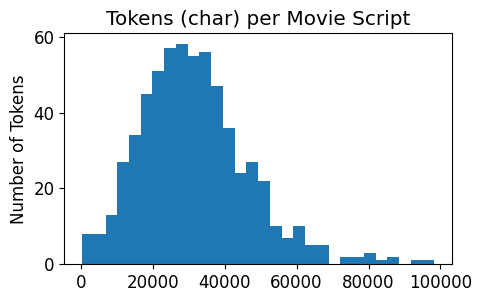

In [ ]:
# Plot # of tokens per movie script
plt.figure(figsize=(5, 3))
plt.hist(rating_dataset_df['movie_script'].apply(lambda x: len(x)), bins=30)
plt.ylabel('Number of Tokens')
plt.title('Tokens (char) per Movie Script')
plt.show()

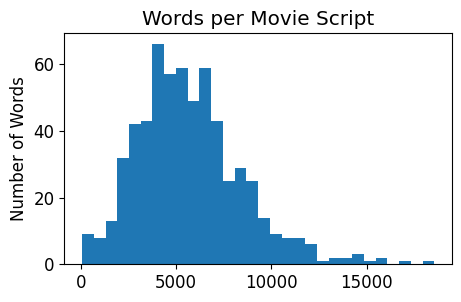

In [ ]:
# Plot # of words per movie script
plt.figure(figsize=(5, 3))
plt.hist(rating_dataset_df['movie_script'].apply(lambda x: len(x.split())), bins=30)
plt.ylabel('Number of Words')
plt.title('Words per Movie Script')
plt.show()

In [ ]:
# Retrieve only the middle of the script due to max tokens in transformer models and vectorizers
rating_dataset_df['movie_script'] = rating_dataset_df['movie_script'].apply(lambda x: x[int(len(x)*0.3):int(len(x)*0.7)])

In [ ]:
# Split the dataset into training and test sets with an 80-20 split
script_train_df, script_test_df = train_test_split(rating_dataset_df, test_size=0.2)

# Transforming text data to TF-IDF features
vectorizer_script = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
train_script_vectors = vectorizer_script.fit_transform(script_train_df['movie_script'].values)
test_script_vectors = vectorizer_script.transform(script_test_df['movie_script'].values)

print(train_script_vectors.shape)

(493, 6637)


In [ ]:
vocab = vectorizer_script.get_feature_names_out()
print(f'Length of vocabulary (train): {len(vocab)}')
print()
print(f"Average document vocabulary size (train): {train_script_vectors.count_nonzero()/train_script_vectors.get_shape()[0]}")
print()
print('Sample vocabulary terms (train):')
print(sorted(random.sample(vocab.tolist(),100)))

Length of vocabulary (train): 6637

Average document vocabulary size (train): 366.54361054766736

Sample vocabulary terms (train):
['absence', 'ambitious', 'analysis', 'annoy', 'anyways', 'assure', 'attitude', 'bible', 'birds', 'bombed', 'booked', 'break', 'buck', 'buff', 'bureau', 'buttons', 'cabin', 'cable', 'cheer', 'closing', 'confused', 'continue', 'cooler', 'crawford', 'defence', 'deserve', 'disappointed', 'doctors', 'doubt', 'dragon', 'drill', 'dumped', 'edge', 'edna', 'episode', 'episodes', 'fascinating', 'fed', 'fingerprints', 'flashlight', 'flat', 'flatter', 'francis', 'fried', 'heels', 'hides', 'ho', 'hunter', 'iii', 'implications', 'incredibly', 'inspired', 'involve', 'irs', 'island', 'lifetime', 'line', 'lion', 'mature', 'members', 'military', 'organize', 'pink', 'places', 'porch', 'porno', 'preoccupied', 'profits', 'ran', 'registration', 'relations', 'retire', 'review', 'robbed', 'sack', 'scientists', 'seek', 'selfish', 'shirt', 'shooting', 'skull', 'soda', 'spare', 'spri

In [ ]:
# Train and test inputs
X_train = train_script_vectors
X_test = test_script_vectors

# Train and test rating outputs
y_train = script_train_df['movie_rating'].values
y_test = script_test_df['movie_rating'].values

# Random test set index
random_test_index = random.randint(0, len(y_test)-1)

**Models**

In [ ]:
# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Save model
with open('LinReg_rating_regression.pkl', 'wb') as f:
    pickle.dump(model, f)

# Classification report
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))

# Random test sample performance
print('\nExample performance on random test sample:')
print('Title:',script_test_df['movie_title'].iloc[random_test_index])
print(script_test_df['movie_script'].iloc[random_test_index][:200]+'...\n')
pred = model.predict(X_test[random_test_index])
print(f'Predicted: {pred}')
print(f'True: {y_test[random_test_index]}')

MSE: 7.920963276249122
R2 score: -5.774377013513034

Example performance on random test sample:
Title: the black dahlia
ix weeks he'll be sucking gas. In three years I'll be working Central Warrants. Jewboy Deputy D.A. over there wets his pants for fighters. Promised me the next spot he can wangle.
BUCKY: Impressive.
L...

Predicted: [7.86298678]
True: 5.599999904632568


In [ ]:
# Linear Regression model
model = SVR()
model.fit(X_train, y_train)

# Save model
with open('SVR_rating_regression.pkl', 'wb') as f:
    pickle.dump(model, f)

# Classification report
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))

# Random test sample performance
print('\nExample performance on random test sample:')
print('Title:',script_test_df['movie_title'].iloc[random_test_index])
print(script_test_df['movie_script'].iloc[random_test_index][:200]+'...\n')
pred = model.predict(X_test[random_test_index])
print(f'Predicted: {pred}')
print(f'True: {y_test[random_test_index]}')

MSE: 1.2410439717831359
R2 score: -0.06139865342082129

Example performance on random test sample:
Title: the black dahlia
ix weeks he'll be sucking gas. In three years I'll be working Central Warrants. Jewboy Deputy D.A. over there wets his pants for fighters. Promised me the next spot he can wangle.
BUCKY: Impressive.
L...

Predicted: [6.9780599]
True: 5.599999904632568


In [ ]:
# Linear Regression model
model = XGBRegressor()
model.fit(X_train, y_train)

# Save model
with open('XGBRegressor_rating_regression.pkl', 'wb') as f:
    pickle.dump(model, f)

# Classification report
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 score:", r2_score(y_test, y_pred))

# Random test sample performance
print('\nExample performance on random test sample:')
print('Title:',script_test_df['movie_title'].iloc[random_test_index])
print(script_test_df['movie_script'].iloc[random_test_index][:200]+'...\n')
pred = model.predict(X_test[random_test_index])
print(f'Predicted: {pred}')
print(f'True: {y_test[random_test_index]}')

MSE: 1.3713642
R2 score: -0.17285444988433118

Example performance on random test sample:
Title: the black dahlia
ix weeks he'll be sucking gas. In three years I'll be working Central Warrants. Jewboy Deputy D.A. over there wets his pants for fighters. Promised me the next spot he can wangle.
BUCKY: Impressive.
L...

Predicted: [6.456083]
True: 5.599999904632568


None of the models demonstrated good performance, as indicated by their MSE and negative R² scores. Linear Regression was the worst performer, while SVR and XGBoost showed slight improvements. The negative R² scores suggest that all models perform worse than a simple mean prediction. This calls for further model tuning, feature engineering, or exploring alternative models better suited for the dataset to improve predictive performance.

In [ ]:
# Mean prediction metrics
mean_rating = np.repeat(np.mean(y_test), len(y_test))
print("Mean prediction MSE:", mean_squared_error(y_test, mean_rating))
print("Mean prediction  R2 score:", r2_score(y_test, mean_rating))

Mean prediction MSE: 1.1692535
Mean prediction  R2 score: 0.0


**Fine-tune** transformer (DistilBERT)

In [ ]:
# Load the BERT base uncased tokenizer and model from the Hugging Face Transformers library
bert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                           problem_type="regression",
                                                           num_labels=1,
                                                           device_map=str(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Sample dataset due to limited computational resources
script_train_small_df = script_train_df.sample(frac=1)
script_test_small_df = script_test_df.sample(frac=1)

# Build HuggingFace trainer compatible Dataset object
bert_train_data = Dataset.from_dict({'script': script_train_small_df['movie_script'].values.tolist(),
                                     'rating': np.array(script_train_small_df['movie_rating'].values.tolist(), dtype=np.float32)})
bert_test_data = Dataset.from_dict({'script': script_test_small_df['movie_script'].values.tolist(),
                                    'rating': np.array(script_test_small_df['movie_rating'].values.tolist(), dtype=np.float32)})

# Build HuggingFace trainer compatible DatasetDict object
bert_data = DatasetDict()
bert_data['train'] = bert_train_data
bert_data['validation'] = bert_test_data
bert_data['test'] = bert_test_data

In [ ]:
def tokenize_bert_script_function(examples):
  input_encodings = bert_tokenizer(examples['script'], padding='max_length',
                                   truncation=True, max_length=512, return_tensors='pt').to(device)
  sample = {
      'attention_mask': input_encodings.attention_mask,
      'input_ids': input_encodings.input_ids,
      'label': torch.tensor(examples['rating']).to(device)
  }
  return sample

# Convert the input strings into sequences of BERT tokens
tokenized_bert_data = bert_data.map(tokenize_bert_script_function, batched=True, remove_columns=['script', 'rating'])
#tokenized_bert_data.set_format('torch')

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Map:   0%|          | 0/124 [00:00<?, ? examples/s]

Map:   0%|          | 0/124 [00:00<?, ? examples/s]

In [ ]:
# Adapted from: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def compute_metrics(p: EvalPrediction):
  y_pred = p.predictions[0] if isinstance(p.predictions,
          tuple) else p.predictions
  y_true = p.label_ids
  result = {'mse': mean_squared_error(y_true, y_pred)}
  return result

In [ ]:
# Create trainer arguments
rating_training_args = TrainingArguments(
    'script_rating_trainer',
    evaluation_strategy='steps',
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    lr_scheduler_type='linear',
    load_best_model_at_end=True,
    metric_for_best_model='mse',
    bf16=True  # Mixed precision training, to speed up and save memory
)

# Create the trainer
rating_trainer = Trainer(
    model=bert_model,
    args=rating_training_args,
    train_dataset=tokenized_bert_data['train'],
    eval_dataset=tokenized_bert_data['validation'],
    compute_metrics=compute_metrics
)

In [ ]:
# Fine-tune BERT for movie script rating regression
rating_trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=183, training_loss=6.885704165599385, metrics={'train_runtime': 111.6106, 'train_samples_per_second': 13.251, 'train_steps_per_second': 1.64, 'total_flos': 193663883053056.0, 'train_loss': 6.885704165599385, 'epoch': 2.9635627530364372})

In [ ]:
rating_trainer.evaluate()

{'eval_loss': 1.1762980222702026,
 'eval_mse': 1.1762982606887817,
 'eval_runtime': 3.1103,
 'eval_samples_per_second': 39.868,
 'eval_steps_per_second': 5.144,
 'epoch': 2.9635627530364372}

In [ ]:
# Save fine-tuned model
bert_checkpoint_path = 'fine_tuned_distilbert_script_rating_regression'
bert_tokenizer.save_pretrained(bert_checkpoint_path)
bert_model.save_pretrained(bert_checkpoint_path)

In [ ]:
# Retrieve fine-tuned distilBERT model on movie scripts for rating regression
bert_tokenizer = AutoTokenizer.from_pretrained(bert_checkpoint_path)
bert_model = AutoModelForCausalLM.from_pretrained(bert_checkpoint_path, device_map=str(device))

In [ ]:
# Generate output rating of random test sample by fine-tuned BERT
random_sample = script_test_small_df.sample(n=1).iloc[0]
random_script = random_sample['movie_script']
random_target = random_sample['movie_rating']
bert_encoding = bert_tokenizer(random_script,padding='max_length',
                                   truncation=True, max_length=512, return_tensors="pt")
bert_encoding = {k: v.to(device) for k,v in bert_encoding.items()}
prediction = bert_model(**bert_encoding)

# Random test sample performance
print('\nExample performance on random test sample:')
print('Title:', random_sample['movie_title'])
print(random_script[:200]+'...\n')
print()
print(f'Predicted: {prediction.logits[0].item()}')
print(f'True: {random_target}')


Example performance on random test sample:
Title: broadcast news
when I first came up.  I'll get you a great tour.
BUDDY: Forgive me, but it really is intoxicating being a news source.
TOM: Nobody else had it.
BUDDY: I wish it were you giving the story.
TOM: That's...


Predicted: 6.84375
True: 7.099999904632568


Limited by the amount of maximum tokens embeddings for BERT, lack of computational resources, and size of the dataset, the performance of the fine-tuned BERT was similar to the simple mean prediction (almost the same Mean Squared Error).

**Performance comparison**

 - Linear Regression performs poorly, with a high MSE and a highly negative R2 score, indicating it does not fit the data well.

 - SVR and XGBoost show marked improvements with lower MSEs and less negative R2 scores, suggesting better but still suboptimal performance.

 - Fine-tuned DistilBERT limited by max token embedding, had the lowest MSE, demonstrating the best performance among the models.

 - Predicting the mean rating outperforms all models in terms of MSE. This suggests that while sophisticated models can slightly improve predictions, they struggle to surpass the simplicity of mean prediction.

## 3. Extensions

### Movie character chatbot


Chatbot to emulate the responses of a movie character, engaging in conversations that reflect the personality and speech patterns of the character, providing realistic and contextually appropriate replies.

Furthermore, the chatbot is integrated with voice functionality, allowing users to interact with it verbally.

**Speech-to-Text**

In [ ]:
# Adapted from Vicenzo Scotti: https://github.com/vincenzo-scotti/tts_mellotron_api

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
# Loading speech recognition Whisper model
speechRecogModel = whisper.load_model("base")

100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 78.7MiB/s]


**Text-to-Speech**

In [ ]:
# Loading Tacotron model for text-to-speech (need gpu to run)
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to(str(device))
tacotron2.eval()

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip


Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_layer): Linear(in_fea

In [ ]:
# Loading vocoder used to convert the spectrogram into an audio signal
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(str(device))
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

**Fine-tuning GPT-2**

Fine-tune GPT-2 transfomer with context and replies of a movie character.

- In this case the chosen character is **Jack Sparrow** from the movie **Pirates of the Caribbean**

In [ ]:
def get_context_reply_dataset(movie_id, character_id):
  '''
  Extracts context-reply pairs for a specific character in a specific movie.
  param:
  - movie_id (str): Unique identifier of the movie.
  - character_id (str): Unique identifier of the character.
  return:
  - context (list): List of dialogue lines preceding the character's replies
  - reply (list): List of dialogue lines spoken by the specified character
  '''
  context = []
  reply = []
  for conv in dataset.get_conversations_by_movie(movie_id):
    for i in range(1, len(conv)):
      utt_dict = dataset.utterances[conv[i]]
      if utt_dict['character_id'] == character_id:
        context.append(dataset.utterances[conv[i-1]]['text'])
        reply.append(utt_dict['text'])

  return context, reply

In [ ]:
# Get context and reply line of Jack Sparrow
context, reply = get_context_reply_dataset('m159', 'u2470')
dataset_df = pd.DataFrame({'context': context, 'reply': reply})
dataset_df.head()

,context,reply
0,You stole my boat.,AnaMaria! Have you seen Gibbs? I need to put...
1,My dory. The Jolly Mon. Where is it?,Safe! At Port Royal. With the Royal Navy.
2,That boat is my livelihood!,You'll get it back. Or one better.
3,How does he do that?,They'll be anchored on the lee side. Haul you...
4,"Aye, aye, sir!","Mr. Gibbs, organize a cleaning detail -- you a..."


In [ ]:
# Load the GPT-2 medium tokenizer and model from the Hugging Face Transformers library
gpt2_tokenizer = AutoTokenizer.from_pretrained('gpt2-medium')
gpt2_model = AutoModelForCausalLM.from_pretrained('gpt2-medium', device_map=str(device))

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
CHAR_TEXT = '<|character|>'
# Format tokenizer special tokens
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token # for simplification
gpt2_tokenizer.bos_token = '<|beginoftext|>'
gpt2_tokenizer.add_tokens([CHAR_TEXT])

gpt2_model.resize_token_embeddings(len(gpt2_tokenizer))

Embedding(50258, 1024)

In [ ]:
# Format GPT-2 input data as <bos>line<character>line<eos>
dataset_df['gpt2_data'] = dataset_df.apply(lambda x:
                      gpt2_tokenizer.bos_token + x['context'] + CHAR_TEXT + x['reply'] + gpt2_tokenizer.eos_token, axis=1)
dataset_df.head()

,context,reply,gpt2_data
0,You stole my boat.,AnaMaria! Have you seen Gibbs? I need to put...,<|beginoftext|>You stole my boat.<|character|>...
1,My dory. The Jolly Mon. Where is it?,Safe! At Port Royal. With the Royal Navy.,<|beginoftext|>My dory. The Jolly Mon. Where...
2,That boat is my livelihood!,You'll get it back. Or one better.,<|beginoftext|>That boat is my livelihood!<|ch...
3,How does he do that?,They'll be anchored on the lee side. Haul you...,<|beginoftext|>How does he do that?<|character...
4,"Aye, aye, sir!","Mr. Gibbs, organize a cleaning detail -- you a...","<|beginoftext|>Aye, aye, sir!<|character|>Mr. ..."


In [ ]:
# Sample the dataset conversations due to limited computational resources
sample_size = len(context)
sampled_conversations = dataset_df['gpt2_data'].sample(n=sample_size).values

# Split the sampled conversations into train (95%) and validation (5%)
train_conv, val_conv = train_test_split(sampled_conversations, test_size=0.05)

# Build HuggingFace trainer compatible Dataset object
gpt2_train_data = Dataset.from_dict({'text': train_conv})
gpt2_valid_data = Dataset.from_dict({'text': val_conv})

# Build HuggingFace trainer compatible DatasetDict object
gpt2_data = DatasetDict()
gpt2_data['train'] = gpt2_train_data
gpt2_data['validation'] = gpt2_valid_data
gpt2_data['test'] = gpt2_valid_data

In [ ]:
def tokenize_gpt2_function(examples):
  input_encodings = gpt2_tokenizer(examples['text'], padding=True, truncation=True)
  sample = {
      'attention_mask': input_encodings.attention_mask,
      'input_ids': input_encodings.input_ids
  }
  return sample

# Convert the input strings into sequences of GPT-2 tokens
tokenized_gpt2_data = gpt2_data.map(tokenize_gpt2_function, batched=True, remove_columns=['text'])
# Create collator that gets together all the sequences in the same batch
#data_collator = DataCollatorForLanguageModeling(gpt2_tokenizer, mlm=False)

Training

In [ ]:
# Create trainer arguments
character_training_args = TrainingArguments(
    'character_dialogue_generation_trainer',
    evaluation_strategy='steps',
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=6.25e-5,
    lr_scheduler_type="linear",
    bf16=True  # Mixed precision training, to speed up and save memory
)

# Create the trainer
character_trainer = Trainer(
    model=gpt2_model,
    args=character_training_args,
    train_dataset=tokenized_gpt2_data['train'],
    eval_dataset=tokenized_gpt2_data['validation'],
    #data_collator=data_collator
)

In [ ]:
# Fine-tune GPT-2 with specific movie character dialogues
character_trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=150, training_loss=0.9595145670572917, metrics={'train_runtime': 85.1273, 'train_samples_per_second': 3.524, 'train_steps_per_second': 1.762, 'total_flos': 65299267584000.0, 'train_loss': 0.9595145670572917, 'epoch': 3.0})

In [ ]:
# Save fine-tuned model
gpt2_checkpoint_path = 'fine_tuned_gpt2_character_dialogue_generation'
gpt2_tokenizer.save_pretrained(gpt2_checkpoint_path)
gpt2_model.save_pretrained(gpt2_checkpoint_path)

Character dialogue generation

In [ ]:
# Retrieve fine-tuned GPT-2 model on specific movie character dialogues
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_checkpoint_path)
gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_checkpoint_path , device_map=str(device))

In [ ]:
def generate_character_dialogue(model, tokenizer, context):
  '''
  Generates dialogue for a character based on the given context
  params:
  - model (transformers.PreTrainedModel): Pre-trained language model
  - tokenizer (transformers.PreTrainedTokenizer): Tokenizer corresponding to the pre-trained language model
  - context (str): Initial context or prompt for which the dialogue should be generated
  returns:
  String generated of dialogue continuation
  '''
  model_inputs = tokenizer.bos_token + context + CHAR_TEXT
  input_encoding = tokenizer(model_inputs, return_tensors='pt').to(device)
  output_ids = model.generate(input_encoding.input_ids, max_new_tokens=32,
                              pad_token_id=tokenizer.eos_token_id)
  output_dialogue = tokenizer.decode(output_ids[0, input_encoding.input_ids.size(1):], skip_special_tokens=True)
  return output_dialogue

In [ ]:
for _ in range(3):
  user_context = input('PIRATE: ')
  character_reply = generate_character_dialogue(gpt2_model, gpt2_tokenizer, user_context)
  print(f'JACK SPARROW: {character_reply}')

PIRATE: What it's the plan?
JACK SPARROW: I've got a plan.  I've got a way to get out of this island.  I've got a way to get back to the mainland.
PIRATE: Let me help you.
JACK SPARROW: I'll be right back.  We have a few hours.
PIRATE: Where are you going?
JACK SPARROW: I'm going to the Black Pearl.  I've heard of it.  I've seen it.


The Jack Sparrow chatbot captures his adventurous and evasive tone, however responses are overly verbose and somewhat repetitive.

Moreover, due to the way the model was fine-tuned, the chatbot does not retain the context of the whole conversation to generate its replies.

Overall, the chatbot performs quite good generating replies in the context of the movie, the personality of the character and its role in the movie. Further training with larger dataset, more computational resources and bigger model could produce even better results.

**Chatbot**

In [ ]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
def start_chatbot(max_exchanges):
  dialogue_history = []

  for _ in range(max_exchanges):
    # ----- USER ------
    # Record audio
    input('Press any key to start the recording ...')
    print('YOU : ')
    user_audio, sr = get_audio()
    display(Audio(user_audio, rate=sr))
    wav_write('recording.wav', sr, user_audio)
    # Speech-to-Text
    whisper_result = speechRecogModel.transcribe('recording.wav')
    user_message = whisper_result['text']
    dialogue_history.append(user_message)

    # ----- BOT ------
    chatbot_response = generate_character_dialogue(gpt2_model, gpt2_tokenizer, user_context)
    dialogue_history.append(chatbot_response)
    # Text-to-Speech
    sequences, lengths = utils.prepare_input_sequence([chatbot_response])
    with torch.no_grad():
      mel, _, _ = tacotron2.infer(sequences, lengths)
      audio = waveglow.infer(mel)
    audio_numpy = audio[0].data.cpu().numpy()
    print('BOT : ')
    display(Audio(audio_numpy, rate=22050, autoplay=True))
  return dialogue_history

In [ ]:
# Chatbot
chat_history = start_chatbot(3)

Press any key to start the recording ...
YOU : 


BOT : 


Press any key to start the recording ...
YOU : 


BOT : 


Press any key to start the recording ...
YOU : 


BOT : 


In [ ]:
# Print generated chat
characters = ['PIRATE', 'JACK SPARROW']
first_char = True
for line in chat_history:
  if first_char:
    print(f'{characters[0]}: {line}')
    first_char = False
  else:
    print(f'{characters[1]}: {line}')
    first_char = True

PIRATE:  What is the plan?
JACK SPARROW: The island.  We're going to the Black Pearl.  We're going to the island where the pirates are going to be killed.  We're going
PIRATE:  Can I be part of your crew?
JACK SPARROW: I'm going to the Black Pearl.
PIRATE:  Let me go with you.
JACK SPARROW: I've already found you a mate.


As depicted, it is possible to have a voice conversation with chatbot Jack Sparrow. The speech-to-text and text-to-speech mechanism worked properly, and the Jack Sparrow generated response where coherent regarding the role of the character in the movie.

**Potential improvement**
- Larger dataset and more computational resources
- Fine-tune larger LLM
- Fine-tune allowing to generate responsing with a larger conversation context
- Chatbot text-to-speech with a male voice or similar to the character
- Fine-tune vocoencoder to produce text-to-speech utterance as the movie character